# Imports

In [1]:
# Estándar
from collections import Counter
import warnings
import time

# Núcleo científico
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, precision_recall_fscore_support
)

# Modelos clásicos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

# Desbalanceo de clases
from imblearn.over_sampling import SMOTE

# Algoritmos de boosting
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from lightgbm import LGBMClassifier

# Configuración global
warnings.filterwarnings("ignore")  # Silencia warnings innecesarios



# Entrada de Datos

In [2]:
# Leemos el archivo CSV con los datos
df = pd.read_csv('email_phishing_data.csv', delimiter=',')

# Mostramos el número de filas (entradas) y columnas (variables)
nRow, nCol = df.shape
print(f'Nº entradas: {nRow} , Nº columnas: {nCol} ')

# Distribución de la variable objetivo 'label'
dist_label = (
    df['label']
    .value_counts()
    .rename_axis('Clase')
    .reset_index(name='Frecuencia')
)

display(dist_label)

Nº entradas: 524846 , Nº columnas: 9 


,Clase,Frecuencia
0,0,517897
1,1,6949


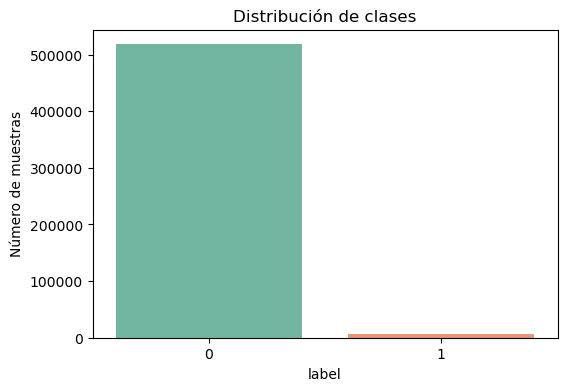

In [3]:
# Gráficamos la distribución
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette="Set2")
plt.title("Distribución de clases")
plt.ylabel("Número de muestras")
plt.show()


Despues de leer los datos y ver la distribución de la clase objetivo, se puede ver un fuerte desbalanceo, dominando la clase no phising por un gran margen. Lo cual, podría ser un problemas para algunas pruebas pero se tratará en el preprocesamiento.

Ahora procedermos a ver  más características de estos datos y comentarlos

In [4]:
# Resumen estadístico de las variables
df.describe()

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
count,5.248460e+05,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000
mean,2.762280e+02,123.012167,80.045465,0.895588,0.347767,2.114897,24.694731,0.245301,0.013240
std,3.335457e+03,201.626478,1023.330380,5.603001,1.774209,13.592682,311.312358,0.559320,0.114301
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.700000e+01,38.000000,12.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,1.200000e+02,79.000000,34.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000
75%,2.690000e+02,145.000000,79.000000,0.000000,0.000000,1.000000,22.000000,0.000000,0.000000
max,2.339682e+06,51251.000000,720411.000000,824.000000,524.000000,1150.000000,190104.000000,7.000000,1.000000


In [5]:
# Información general 
df.info()

# Resumen del mínimo, máximo y media de las variables
df.describe().T[['min','max','mean']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524846 entries, 0 to 524845
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   num_words            524846 non-null  int64
 1   num_unique_words     524846 non-null  int64
 2   num_stopwords        524846 non-null  int64
 3   num_links            524846 non-null  int64
 4   num_unique_domains   524846 non-null  int64
 5   num_email_addresses  524846 non-null  int64
 6   num_spelling_errors  524846 non-null  int64
 7   num_urgent_keywords  524846 non-null  int64
 8   label                524846 non-null  int64
dtypes: int64(9)
memory usage: 36.0 MB


,min,max,mean
num_words,0.0,2339682.0,276.228000
num_unique_words,0.0,51251.0,123.012167
num_stopwords,0.0,720411.0,80.045465
num_links,0.0,824.0,0.895588
num_unique_domains,0.0,524.0,0.347767
num_email_addresses,0.0,1150.0,2.114897
num_spelling_errors,0.0,190104.0,24.694731
num_urgent_keywords,0.0,7.0,0.245301
label,0.0,1.0,0.013240


In [6]:
# Comprobamos valores nulos en cada columna
df.isnull().sum()

num_words              0
num_unique_words       0
num_stopwords          0
num_links              0
num_unique_domains     0
num_email_addresses    0
num_spelling_errors    0
num_urgent_keywords    0
label                  0
dtype: int64

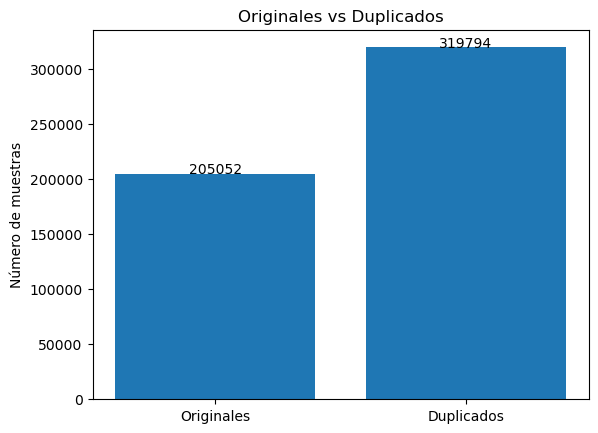

In [7]:
# Comprobamos el número de duplicados
duplicados = df.duplicated().sum()
total = len(df)
sin_duplicados = total - duplicados

# Preparamos los valores para graficar
valores = [sin_duplicados, duplicados]
categorias = ['Originales', 'Duplicados']

# Creamos un gráfico de barras comparando duplicados y originales
plt.bar(categorias, valores)
plt.title("Originales vs Duplicados")
plt.ylabel("Número de muestras")
plt.xlabel("")

# Mostrar valores encima de cada barra
for i, v in enumerate(valores):
    plt.text(i, v + 1, str(v), ha='center')

plt.show()



Tras todo esto podemos ver:
- Todas las variables son de tipo **int64**, por lo que no será necesario realizar conversiones adicionales para el entrenamiento.  
- No se detectan **valores nulos** en el dataset.  
- Existe un **alto número de registros duplicados** (más del 50% del total), lo que podría afectar negativamente el rendimiento de varios modelos.  
- También hay muchas variables que tienen medias bajas en comparación con sus máximos, lo que indica una distribución irregular y la posible presencia de **outliers** (ej. `num_spelling_errors` con media ~25 y máximo >190.000). 

# Preprocesamiento 

Tras la exploración inicial de los datos, se procederá a eliminar las entradas duplicadas del dataset, normalización/estandarización de las variables y aplicación de una técnica de oversampling para tratar de equilibrar el número de clases phising.

Número de duplicados después de limpiar: 0
Tamaño nuevo: (205052, 9)


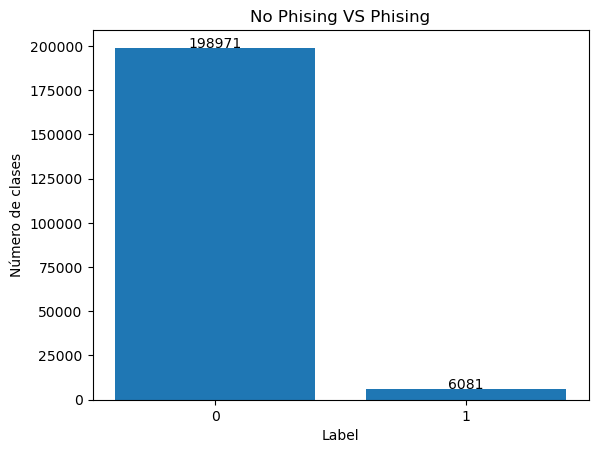

In [8]:
# Eliminación de duplicados
df_clean = df.drop_duplicates()

# Confirmamos que ya no queden duplicados
print("Número de duplicados después de limpiar:", df_clean.duplicated().sum())
print("Tamaño nuevo:", df_clean.shape)


# Visualización de la distribución de clases
categorias = df_clean['label'].value_counts().index.astype(str)   # ['0', '1']
valores = df_clean['label'].value_counts().values                 # cantidades

plt.bar(categorias, valores)
plt.title("No Phising VS Phising")
plt.ylabel("Número de clases")
plt.xlabel("Label")

# Mostrar el valor numérico encima de cada barra
for i, v in enumerate(valores):
    plt.text(i, v + 1, str(v), ha='center')

plt.show()

A pesar de haber eliminado más de la mitad de las entradas por duplicados, el dataset resultante aún conserva un volumen considerable (cerca de 200.000 registros).  
Esta cantidad es suficiente para entrenar los modelos, y además se verá incrementada posteriormente mediante la técnica de **oversampling (SMOTE)** para equilibrar las clases.


Ahora veremos la distribución de las variables

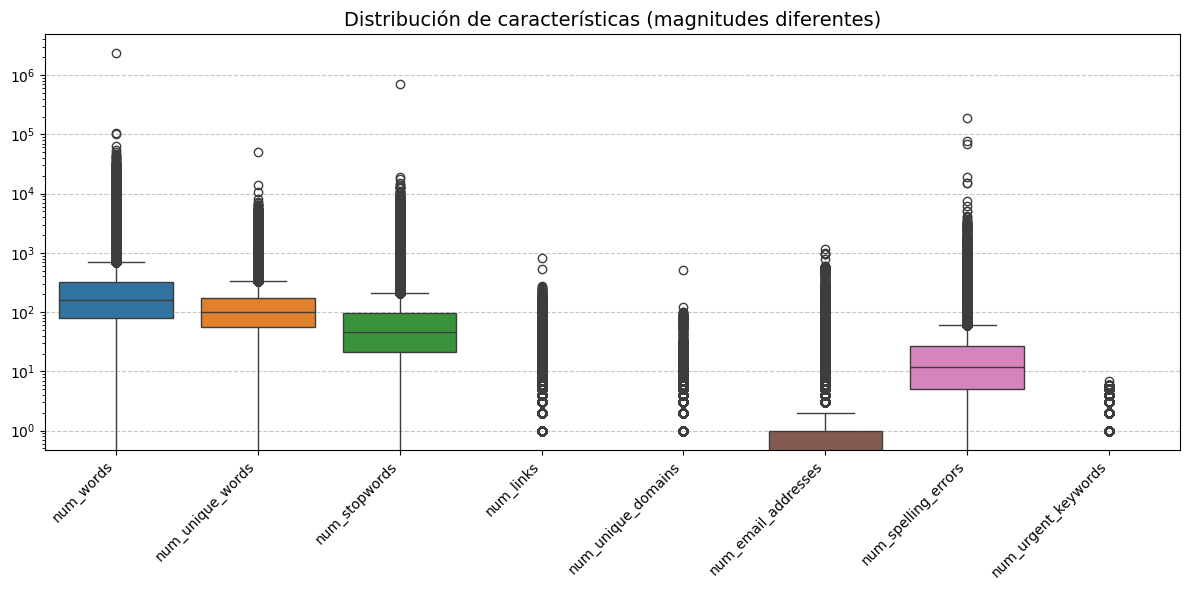

In [9]:
# Seleccionamos todas las columnas excepto la variable objetivo
features = [col for col in df_clean.columns if col != "label"]

# Gráfico de caja (boxplot) para todas las variables
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[features])

# Ajustes de estilo
plt.title("Distribución de características (magnitudes diferentes)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yscale("log")  # Usamos escala logarítmica para visualizar mejor las diferencias de magnitud
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


El boxplot evidencia las **diferencias de escala** entre las variables.
- Algunas variables, como `num_words`, `num_unique_words`, `num_stopwords`, `num_spelling_errors` presentan valores muy superiores a su media.  
- Otras, como `num_links`, `num_unique_domains` o `num_email_addresses`, tienen valores bastante pequeños en comparación a los anteriores.  
- Se observa además una gran cantidad de **outliers** en la mayoría de las variables, especialmente en `num_spelling_errors` y `num_words`.

Con esta información podemos ver que variables necesitan mayor escalado que otras y se tendrán en cuenta para el escalado.



In [10]:
# Transformación y escalado de variables

# Definimos dos grupos de variables:
#  - features_log: variables con distribuciones más grandes y con valores extremos (colas largas)
#  - features_only_scale: variables con escalas más pequeñas pero que requieren estandarización
features_log = ['num_words','num_unique_words','num_stopwords','num_spelling_errors']
features_only_scale = ['num_links','num_unique_domains','num_email_addresses','num_urgent_keywords']

# Creamos una copia del conjunto de características
X = df_clean[features_log + features_only_scale].copy()

# Aplicamos la transformación logarítmica a las variables de mayor magnitud
for col in features_log:
    X[col] = np.log1p(X[col])

# Aplicamos un escalado estándar (media 0, desviación estándar 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertimos el resultado a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=features_log + features_only_scale)

# Variable objetivo (label)
y = df_clean["label"]



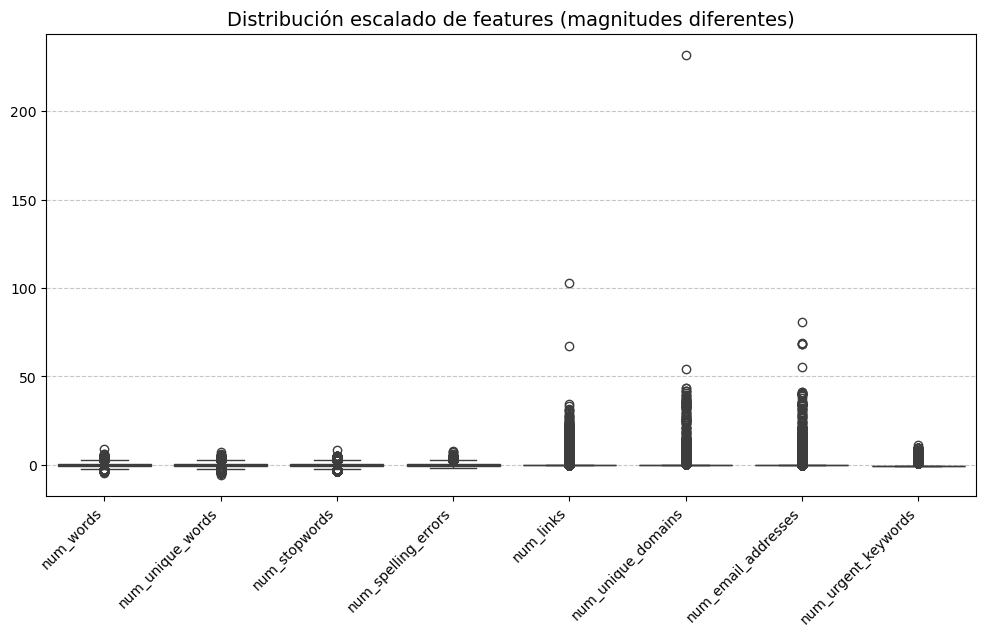

In [11]:
# Boxplot de las variables después del escalado estándar
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_scaled_df)

# Ajustes visuales
plt.title("Distribución escalado de features (magnitudes diferentes)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.show()


In [12]:
# Resumen estadístico después del escalado
X_scaled_df.describe()

,num_words,num_unique_words,num_stopwords,num_spelling_errors,num_links,num_unique_domains,num_email_addresses,num_urgent_keywords
count,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05
mean,1.421955e-15,-6.044579e-16,9.392552e-16,7.698771e-17,-4.833930e-18,-8.602317e-18,-1.898920e-17,-4.792348e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-4.771236e+00,-5.521543e+00,-3.289626e+00,-2.086851e+00,-1.787802e-01,-2.112157e-01,-1.722294e-01,-4.921905e-01
25%,-6.881146e-01,-6.667945e-01,-6.417724e-01,-6.285977e-01,-1.787802e-01,-2.112157e-01,-1.722294e-01,-4.921905e-01
50%,-3.067303e-02,-1.550758e-02,8.493430e-03,6.756711e-04,-1.787802e-01,-2.112157e-01,-1.722294e-01,-4.921905e-01
75%,6.266265e-01,6.259348e-01,6.466527e-01,6.251189e-01,-1.787802e-01,-2.112157e-01,-1.017155e-01,-4.921905e-01
max,8.893930e+00,7.444374e+00,8.264124e+00,7.805967e+00,1.029207e+02,2.320032e+02,8.091878e+01,1.100657e+01


In [13]:
# Resumen del mínimo, máximo y media
X_scaled_df.describe().T[['min','max','mean']]

,min,max,mean
num_words,-4.771236,8.893930,1.421955e-15
num_unique_words,-5.521543,7.444374,-6.044579e-16
num_stopwords,-3.289626,8.264124,9.392552e-16
num_spelling_errors,-2.086851,7.805967,7.698771e-17
num_links,-0.178780,102.920683,-4.833930e-18
num_unique_domains,-0.211216,232.003186,-8.602317e-18
num_email_addresses,-0.172229,80.918775,-1.898920e-17
num_urgent_keywords,-0.492190,11.006572,-4.792348e-17


Después de aplicar la transformación logarítmica y el escalado estándar, las variables presentan medias cercanas a **0** y desviaciones estándar próximas a **1**, lo que significa que el escalado fuen un éxito.

En el boxplot, las distribuciones de las características ya aparecen acorde a esta normalización. Las grandes diferencias de magnitud observadas antes del escalado han desaparecido, aunque todavía se aprecian algunos valores atípicos (outliers), especialmente en las variables `num_links` y `num_unique_domains`. Estos valores extremos no afectan de manera significativa al conjunto de datos.

En conjunto, el siguiente paso sería hacer una partición de los datos y el oversampling.

## Split y  Oversampling

Ahora se procederá a relizar una parttición 80/20 de los datos escalados, junto a la técnica de sobremuestreo **Smote**, con el objetivo de mitigar el desbalanceo entre clases y mejorar la capacidad de generalización de los modelos.

In [14]:
# 1) Split estratificado 80/20
#    - Estratificamos por 'y' para conservar la proporción de clases en train y test.
X = X_scaled_df
y = df_clean["label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2) SMOTE solo en TRAIN
print("Train antes:", Counter(y_train))
sm = SMOTE(sampling_strategy=0.3, random_state=42) # La clase minoritaria ahora pasará a ser el 30% del set
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Train después:", Counter(y_train_res))

Train antes: Counter({0: 159176, 1: 4865})
Train después: Counter({0: 159176, 1: 47752})


Con este resultado, se puede observar que el sobremuestreo fue logrado, rondado cerca del 30% en el set de entrenamiento.

In [121]:
# Comprobamos la distribución de clases en el conjunto de test
print("Test balance:", Counter(y_test))
print("Proporciones en test:")
display(pd.DataFrame({
    "Cantidad": y_test.value_counts().sort_index(),
    "Proporción (%)": (y_test.value_counts(normalize=True).sort_index() * 100).round(2)
}))


Test balance: Counter({0: 39795, 1: 1216})
Proporciones en test:


,Cantidad,Proporción (%)
label,,
0,39795,97.03
1,1216,2.97


Sin embargo, no lo aplicamos en el conjunto de test. El objetivo es que, durante la fase de evaluación, los modelos se enfrenten a un conjunto de datos con una distribución similar a la de un caso real, posiblemente muy desbalanceado.

Estos serán todos los conjuntos de entrenamiento y test que se usarán en las pruebas de los algoritmos de machine learning

In [ ]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.4, k_neighbors=7, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)

input_dim = X_tr_res.shape[1] # número de features


# Modelo MLP (512-256-128-64)
model3 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(512, activation="swish", kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation="swish", kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation="swish", kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation="swish", kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])


# Optimizador AdamW con weight decay y clipping para mayor estabilidad
optimizer = keras.optimizers.AdamW(
    learning_rate=3e-4, weight_decay=1e-4, clipnorm=1.0
)

# Compilación
model3.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=10, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=4, min_lr=1e-5)

# Entrenamiento
start = time.time()

history3 = model3.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),  
    epochs=150,
    batch_size=512,
    callbacks=[early, rlrop],
    verbose=1
)

train_time_MLP3 = time.time() - start

In [ ]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)


# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)

input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (256-128-64)
model5 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

# Compilación
model5.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=8, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=3, min_lr=1e-5)

# Entrenamiento
start = time.time()

history5 = model5.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),     
    epochs=100, batch_size=256,   
    callbacks=[early, rlrop],
    verbose=0
)

train_time_MLP5 = time.time() - start

# Entrenamiento de modelos

Antes de entrenar ningun modelo, definiremos 2 funciones para graficar los resultados  con las métricas adeecuadas y también mostrar numéricamente.

In [122]:
def evaluar_modelo(model, X_test, y_test, nombre="Modelo", threshold=0.5, train_time=None):
    """
    Evalúa un modelo con las métricas clave:
    - Matriz de confusión
    - Precision, Recall, F1 y PR AUC (Average Precision)
    - Tiempo de entrenamiento
    
    Parámetros:
    - model: clasificador entrenado
    - X_test, y_test: datos de test
    - nombre: etiqueta del modelo (para imprimir)
    - threshold: umbral de decisión (por defecto = 0.5)
    - train_time: tiempo de entrenamiento en segundos
    """
    
    # Obtenemos probabilidades 
    if hasattr(model, "predict_proba"):       
        # Si el modelo tiene método predict_proba
        y_proba = model.predict_proba(X_test)[:, 1] 
    elif hasattr(model, "decision_function"):
        # Si no tiene predict_proba, normalizamos los scores a [0,1]
        scores = model.decision_function(X_test)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    else:
        # Si el modelo no permite calcular probabilidades
        raise ValueError("El modelo no permite calcular probabilidades.")
    
    # Predicciones según el umbral(threshold) elegido
    y_pred = (y_proba >= threshold).astype(int)


    # Cálculo de métricas
    print(f"=== Evaluación de {nombre} (threshold={threshold}) ===")
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

    # Métricas principales  
    f1_pos = f1_score(y_test, y_pred, pos_label=1)
    rec_pos = recall_score(y_test, y_pred, pos_label=1)
    pr_auc = average_precision_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    precision_global = accuracy_score(y_test, y_pred)            # precision general de ambas clases

    # Mostrar resultados
    print(f"Precision global: {precision_global:.4f}")
    print(f"Precision (clase 1): {precision:.4f}")
    print(f"Recall (clase 1): {rec_pos:.4f}")
    print(f"F1 (clase 1): {f1_pos:.4f}")
    print(f"PR AUC (Average Precision): {pr_auc:.4f}")

    # Mostrar tiempo de entrenamiento
    if train_time is not None:
        print(f"Tiempo de entrenamiento: {train_time:.4f} segundos \n")
    else:
        print(f"Tiempo de entrenamiento: no disponible\n")

def graficar_modelo(model, X_test, y_test, nombre="Modelo", threshold=0.5, train_time=None):
    """
    Genera tres gráficas clave para la evaluación del modelo:
      - Matriz de confusión
      - Curva Precision–Recall (con PR AUC)
      - Precision / Recall / F1/ Precision global(Accuracy) para el umbral indicado
    """
    #  Obtenemos probabilidades 
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    else:
        raise ValueError("El modelo no expone predict_proba ni decision_function.")

    # Usamos el threshold definido
    y_pred = (y_proba >= threshold).astype(int)
    
    # Configuración de figura y subgráficos
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2], wspace=0.25, hspace=0.30)

    # 1) Matriz de confusión
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax1)
    ax1.set_title(f"Matriz de confusión — {nombre}")
    ax1.set_xlabel("Predicción"); ax1.set_ylabel("Real")

    # 2) Curva Precision–Recall (con PR AUC)
    ax2 = fig.add_subplot(gs[0, 1])
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    ax2.plot(rec, prec, linewidth=2, label=f"PR AUC = {ap:.3f}")
    ax2.set_title(f"Curva Precision–Recall — {nombre}")
    ax2.set_xlabel("Recall"); ax2.set_ylabel("Precision")
    ax2.legend(loc="lower left")

    # 3) Precision / Recall / F1 en el threshold elegido
    ax3 = fig.add_subplot(gs[1, :])
    precision_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall_1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    precision_global= accuracy_score(y_test, y_pred)

    # Valores y etiquetas para gráfico de barras
    metrics = [precision_1, recall_1, f1_1, precision_global]
    labels  = ["Precision_1", "Recall_1", "F1_1", "Precision_global"]

    ax3.bar(labels, metrics, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"])
    ax3.set_ylim(0, 1)
    ax3.set_title(f"Métricas principales (threshold = {threshold}) — {nombre}")


    plt.tight_layout()
    plt.show()

    # Impresión de métricas
    print(f"Threshold = {threshold}")
    print(f"Precision (clase 1): {precision_1:.4f}")
    print(f"Recall    (clase 1): {recall_1:.4f}")
    print(f"F1        (clase 1): {f1_1:.4f}")
    print(f"PR AUC (Average Precision): {ap:.4f}")
    print(f"Precision global: {precision_global:.4f}")

    if train_time is not None:
        print(f"Tiempo de entrenamiento: {train_time:.4f} segundos\n")
    else:
        print(f"Tiempo de entrenamiento: no disponible\n")


## Suppor Vector Machine

### Experimento 1

En esta primera prueba se usará el modelo lineal para ver el rendimiento base de este algortimo

In [17]:
svm_lin1 = LinearSVC(C=1.0, random_state=42)  

# Entrenamiento
start = time.time()
svm_lin1.fit(X_train_res, y_train_res)
train_time_SVM1 = time.time() - start

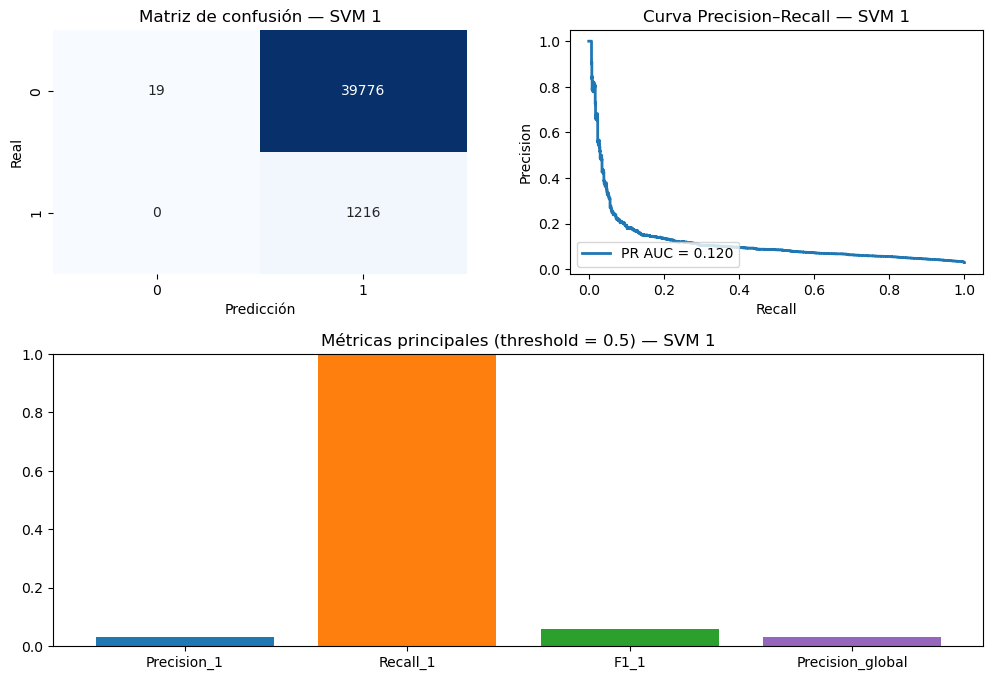

Threshold = 0.5
Precision (clase 1): 0.0297
Recall    (clase 1): 1.0000
F1        (clase 1): 0.0576
PR AUC (Average Precision): 0.1200
Precision global: 0.0301
Tiempo de entrenamiento: 0.7117 segundos


In [18]:
# Evaluacion
graficar_modelo(svm_lin1, X_test, y_test, nombre="SVM 1", threshold=0.5, train_time=train_time_SVM1)

Como se puede observar se alcanzó un recall perfecto (1.0) logrando detectar todos los correos phishing y en tiempo muy pequeño, prácticamente instantáneo. Sin embargo, el resto de las métricas muestran un nivel demasiado bajo, lo que significa que se marca gran parte de los correos como phishing, generando demasiadas falsas alarmas.

Se intentará alguna prueba más con la version lineal para ver si se puede conseguir alguna mejora, sino se probará con la versión que usa el kernel no lineal.

### Experimento 2

Ahora solo se cambio el valor de  **C** a 0.1, para probar si hay alguna mejora notable con una penalización mayor por errores

In [119]:
svm_lin2 = LinearSVC(C=0.1, random_state=42)

# Entrenamiento
start = time.time()
svm_lin2.fit(X_train_res, y_train_res)
train_time_SVM2 = time.time() - start

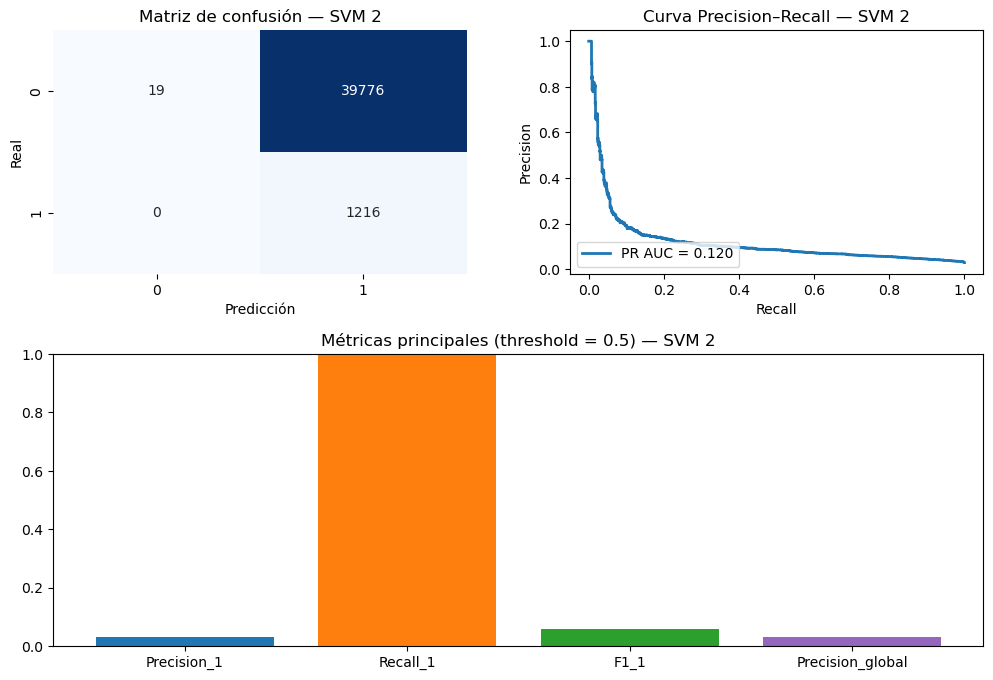

Threshold = 0.5
Precision (clase 1): 0.0297
Recall    (clase 1): 1.0000
F1        (clase 1): 0.0576
PR AUC (Average Precision): 0.1200
Precision global: 0.0301
Tiempo de entrenamiento: 0.3224 segundos


In [120]:
graficar_modelo(svm_lin2, X_test, y_test,
                nombre="SVM 2", threshold=0.5,
                train_time=train_time_SVM2)

Apesar del cambio, el modelo mantiene un comportamiento prácticamente idéntico al de la configuración anterior.  

Se concluye que, incluso con una regularización más fuerte, el modelo lineal no logra separar correctamente las clases, y se probará un modelo con Kernel RBF, que pueda capturar relaciones no lineales entre variables.




### Experimento 3


En este caso se probó con un kernel RBF, teniendo de valores base **C = 1.0** y  **gamma = "scale"**

In [98]:
svm_rbf = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",      
    class_weight=None,  
    random_state=42
)

# Entrenamiento 
start = time.time()
svm_rbf.fit(X_train_res, y_train_res)
train_time_SVM3 = time.time() - start




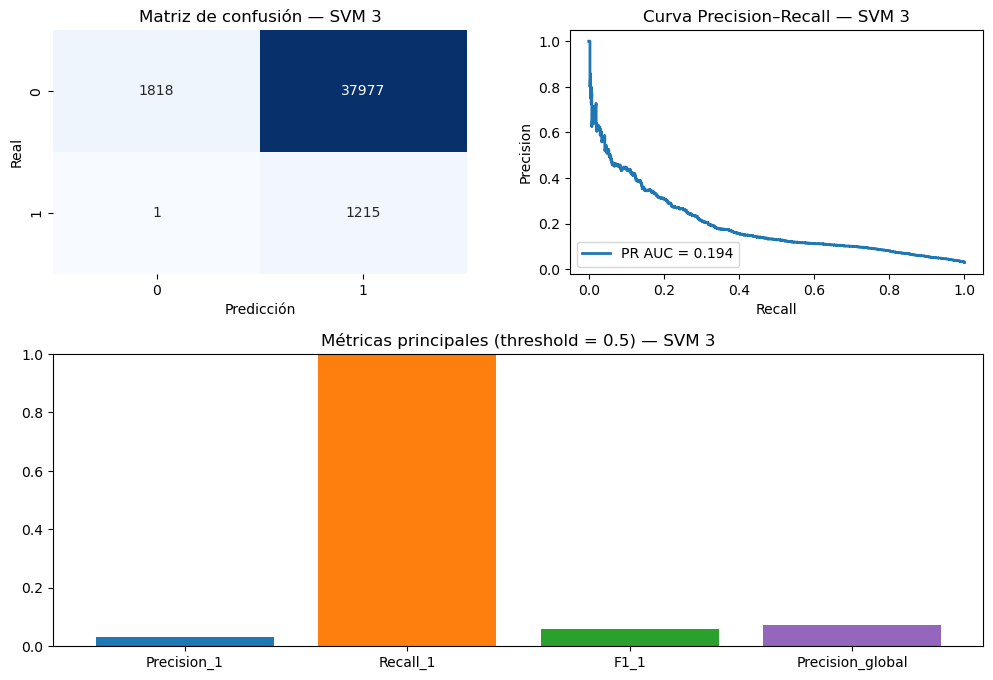

Threshold = 0.5
Precision (clase 1): 0.0310
Recall    (clase 1): 0.9992
F1        (clase 1): 0.0601
PR AUC (Average Precision): 0.1943
Precision global: 0.0740
Tiempo de entrenamiento: 503.3580 segundos


In [99]:
# Evalúa en TEST
graficar_modelo(svm_rbf, X_test, y_test, nombre="SVM 3", threshold=0.5, train_time=train_time_SVM3)

El modelo alcanzó un **PR AUC** de 0.194, mejorando su capacidad discriminativa, pero manteniendo aún el resto de las métricas, además que el tiempo de entrenamiento subió, rondando los 8 minutos en comparación a los poco que duró el anterior. 
Aun así, se intentará realizar más cambios en los hiperparámetros con el fin de obtener una mejora.

### Experimento 4

Se aumento el valor de  **C** a 3.0 para otorgar mas flexibilidad al modelo para ajustar su frontera de decisión.
Además se definió un **cache_size = 2000** y **probabiity = False** con la finalidad de disminuir o mantener a raya el tiempo de entrenamiento.


In [100]:
svm_rbf_2 = SVC(
    kernel="rbf",
    C=3.0,                
    gamma="scale",         
    class_weight=None,   
    probability=False,
    cache_size=2000,
    random_state=42
)

# Entrenamiento

start = time.time()
svm_rbf_2.fit(X_train_res, y_train_res)
train_time_SVM4 = time.time() - start


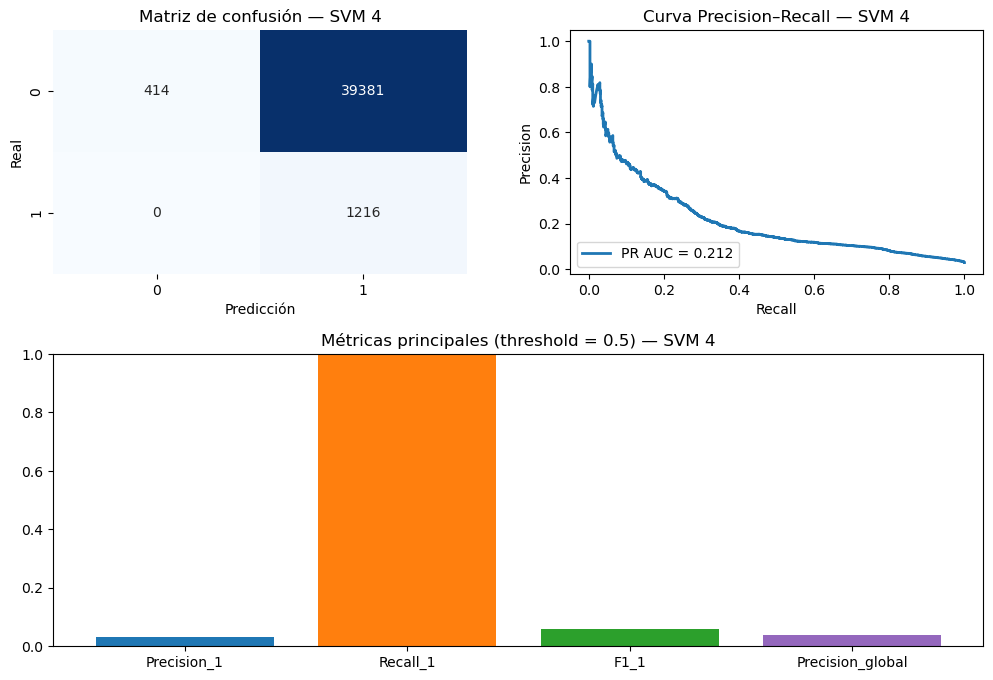

Threshold = 0.5
Precision (clase 1): 0.0300
Recall    (clase 1): 1.0000
F1        (clase 1): 0.0582
PR AUC (Average Precision): 0.2121
Precision global: 0.0397
Tiempo de entrenamiento: 504.6211 segundos


In [101]:
# Evalúa en TEST
graficar_modelo(svm_rbf_2, X_test, y_test,
                nombre="SVM 4", threshold=0.5,train_time=train_time_SVM4)

En este caso se consigió aumentar el **PR AUC** a 0.212, el aumento de **C** ayudó a capturar mejor los patrones, pero se mantienen todavía los mismos problemas y el tiempo apenas cambió. 

### Experimento 5

En este experimento se establece **C = 8.0**, aumentando la flexibilidad, y se define un **gamma = 0.005**, con valores más pequeños hacen que el modelo generalice mejor al ampliar el radio de influencia con el fin de obtener alguna de mejora. 

In [102]:
svm_rbf_3 = SVC(
     kernel="rbf",
    C=8.0,
    gamma=0.005,       
    class_weight=None,
    probability=False,
    cache_size=2000,
    random_state=42
)

# Entrenamiento

start = time.time()
svm_rbf_3.fit(X_train_res, y_train_res)
train_time_SVM5 = time.time() - start


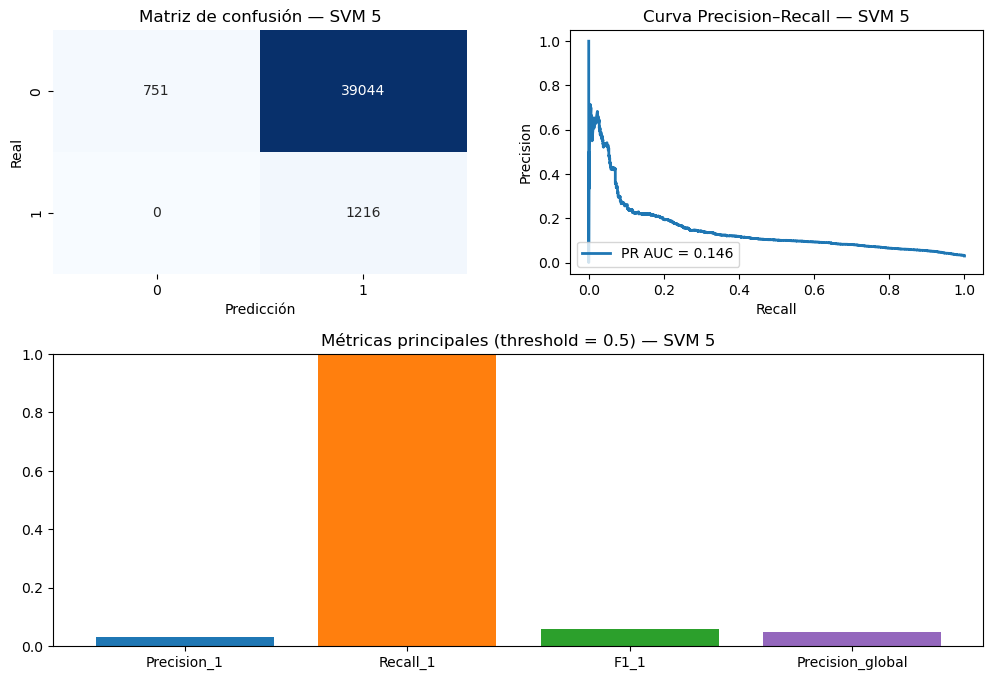

Threshold = 0.5
Precision (clase 1): 0.0302
Recall    (clase 1): 1.0000
F1        (clase 1): 0.0586
PR AUC (Average Precision): 0.1461
Precision global: 0.0480
Tiempo de entrenamiento: 540.5588 segundos


In [103]:
# Evalúa en TEST
graficar_modelo(svm_rbf_3, X_test, y_test,
                nombre="SVM 5", threshold=0.5,train_time=train_time_SVM5)

En esta configuración el rendimiento del modelo empeoro con respecto al anterior, el **PR AUC** desciende de 0.146, reflejando una peor capacidad de discriminación. Este puede deberse a que el valor de **gamma** produjo una frontera de decisión demasiado amplia, reduciendo la capacidad del modelo para capturar patrones, mientras que el aumento de **C** puede haber incrementado el sobreajuste sin aportar mejoras reales.

### Experimento 6

En esta prueba se define **C = 1.5**, reduciendo ligeramente la flexibilidad del modelo para evitar sobreajuste, y se configura **gamma = "auto"**, que ajusta automáticamente su valor en función del número de variables.
Este cambio hace que el modelo sea menos sensible a cada muestra individual, buscando una mejor generalización y una posible reducción de falsos positivos.

In [104]:
svm_rbf_4 = SVC(
    kernel="rbf",
    C=1.5,
    gamma="auto",
    class_weight=None,  
    probability=False,
    cache_size=2000,
    random_state=42
)

# Entrenamiento

start = time.time()
svm_rbf_4.fit(X_train_res, y_train_res)
train_time_SVM6 = time.time() - start


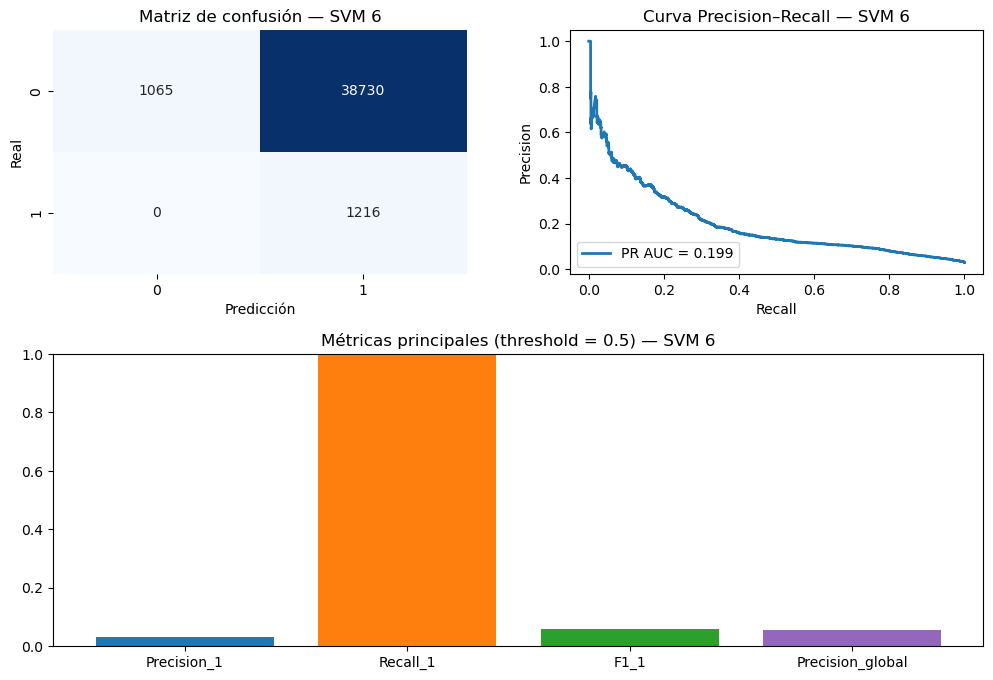

Threshold = 0.5
Precision (clase 1): 0.0304
Recall    (clase 1): 1.0000
F1        (clase 1): 0.0591
PR AUC (Average Precision): 0.1995
Precision global: 0.0556
Tiempo de entrenamiento: 487.1564 segundos


In [105]:
# Evalúa en TEST
graficar_modelo(svm_rbf_4, X_test, y_test,
                nombre="SVM 6", threshold=0.5,train_time=train_time_SVM6)

Se observa una mejora clara con el anterior experimento y aunque mejoró el tiempo de entrenamiento, mantiene todavía los problemas y no el modelo con mayor **PR AUC**.

### Experimento 7

En este caso se activo la opción **class_weight="balanced"**, el cual ayuda a reducir el impacto del desbalanceo de clases. Normalmente esta opción no es buena si el dataset ha sido sobremuestreado, pero se probará si tiene algun efecto positivo el dar mayor importancia a la clase minoritaria.

In [106]:
svm_rbf_5 = SVC(
    kernel="rbf",
    C=1.5,
    gamma="auto",
    class_weight="balanced",
    probability=False,
    cache_size=2000,
    random_state=42
)

# Entrenamiento


start = time.time()
svm_rbf_5.fit(X_train_res, y_train_res)
train_time_SVM7 = time.time() - start


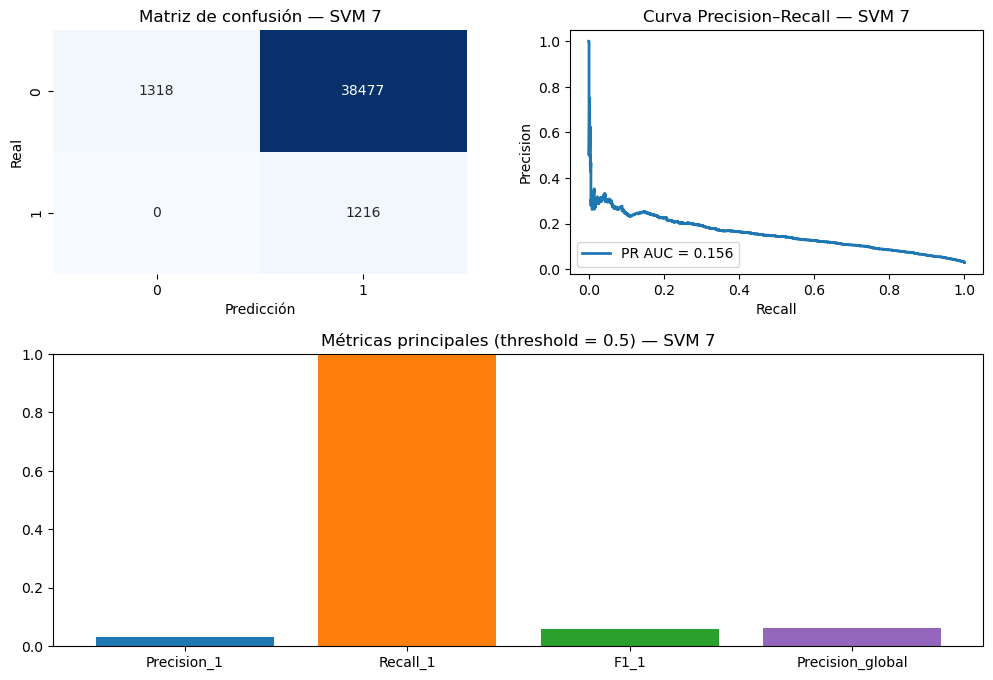

Threshold = 0.5
Precision (clase 1): 0.0306
Recall    (clase 1): 1.0000
F1        (clase 1): 0.0594
PR AUC (Average Precision): 0.1558
Precision global: 0.0618
Tiempo de entrenamiento: 879.6946 segundos


In [107]:
# Evalúa en TEST
graficar_modelo(svm_rbf_5, X_test, y_test,
                nombre="SVM 7", threshold=0.5,train_time=train_time_SVM7)

Con este resultado se ha demostrado de que no es una buena combinación, el tiempo ha subido de forma significativa (cerca de 300 segundos más) y ha emperoado la capacidad discriminativa.

### Experimento 8


En este experimento se mantiene el **C = 8.0** para permitir una mayor flexibilidad en la frontera de decisión y **gamma = "scale"**, que ajusta automáticamente el parámetro en función de la varianza de las características.
Esta opción suele ofrecer un equilibrio adecuado entre precisión y generalización, por lo que el objetivo de esta prueba es comprobar si esta combinación mejora el rendimiento.

In [108]:
svm_rbf_6 = SVC(
    kernel="rbf",
    C=8.0,
    gamma="scale",
    class_weight=None,
    probability=False,
    cache_size=2000,
    random_state=42
)

# Entrenamiento

start = time.time()
svm_rbf_6.fit(X_train_res, y_train_res)
train_time_SVM8 = time.time() - start


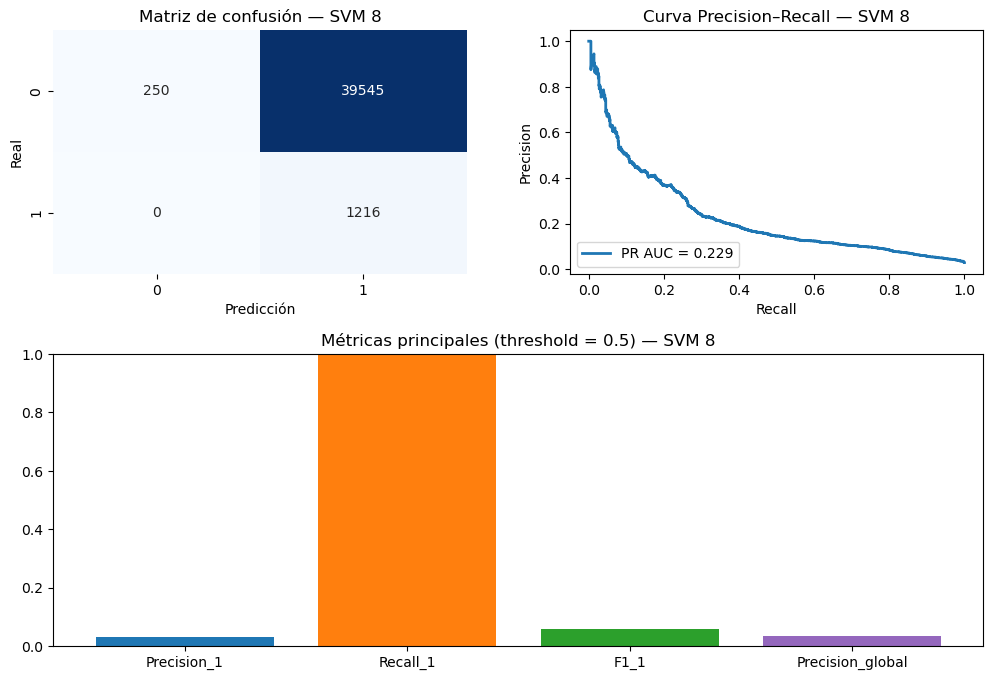

Threshold = 0.5
Precision (clase 1): 0.0298
Recall    (clase 1): 1.0000
F1        (clase 1): 0.0579
PR AUC (Average Precision): 0.2290
Precision global: 0.0357
Tiempo de entrenamiento: 527.4969 segundos


In [109]:
# Evalúa en TEST
graficar_modelo(svm_rbf_6, X_test, y_test,
                nombre="SVM 8", threshold=0.5,train_time=train_time_SVM8)

Esta combinación a permitido al modelo aumentar su capacidad discriminativa, alcanzando el mayor valor de **PR AUC (0.229)** pero todavía manteniendo los problemas acarreados de experimentos anteiores. Entonces se probará a partir de este mismo modelo, ver el efecto que tiene cambiar el umbral (threshold), con el objetivo de analizar si es posible mejorar el equilibrio entre precisión y recall.

In [110]:
evaluar_modelo(svm_rbf_6, X_test, y_test, nombre="SVM 8", threshold=0.3, train_time=train_time_SVM8)
evaluar_modelo(svm_rbf_6, X_test, y_test, nombre="SVM 8", threshold=0.4, train_time=train_time_SVM8)
evaluar_modelo(svm_rbf_6, X_test, y_test, nombre="SVM 8", threshold=0.6, train_time=train_time_SVM8)
evaluar_modelo(svm_rbf_6, X_test, y_test, nombre="SVM 8", threshold=0.7, train_time=train_time_SVM8)
evaluar_modelo(svm_rbf_6, X_test, y_test, nombre="SVM 8", threshold=0.8, train_time=train_time_SVM8)

=== Evaluación de SVM 8 (threshold=0.3) ===
Matriz de confusión:
 [[   55 39740]
 [    0  1216]]
Precision global: 0.0310
Precision (clase 1): 0.0297
Recall (clase 1): 1.0000
F1 (clase 1): 0.0577
PR AUC (Average Precision): 0.2290
Tiempo de entrenamiento: 527.4969 segundos
=== Evaluación de SVM 8 (threshold=0.4) ===
Matriz de confusión:
 [[  126 39669]
 [    0  1216]]
Precision global: 0.0327
Precision (clase 1): 0.0297
Recall (clase 1): 1.0000
F1 (clase 1): 0.0578
PR AUC (Average Precision): 0.2290
Tiempo de entrenamiento: 527.4969 segundos
=== Evaluación de SVM 8 (threshold=0.6) ===
Matriz de confusión:
 [[  591 39204]
 [    0  1216]]
Precision global: 0.0441
Precision (clase 1): 0.0301
Recall (clase 1): 1.0000
F1 (clase 1): 0.0584
PR AUC (Average Precision): 0.2290
Tiempo de entrenamiento: 527.4969 segundos
=== Evaluación de SVM 8 (threshold=0.7) ===
Matriz de confusión:
 [[ 1850 37945]
 [    2  1214]]
Precision global: 0.0747
Precision (clase 1): 0.0310
Recall (clase 1): 0.9984
F1 

Probando con varios valores de umbral, no se ha obtenido ningún cambio significativo, con lo que se procederá a probar otra configuración.

### Experimento 9

Se cambió a **C = 5.0**, buscando equilibrio entre flexibilidad y control de errores,  y se redujo **gamma = 0.01** buscando una frontera más suave que evite el sobreajuste.

Además se ajustaron parámetros de optimización como como **tol = 1e-3** que detiene el entrenamiento cuando la mejora sea mínima, **max_iter = -1** permite que el modelo itere libremente hasta converger y **shrinking = true** que reduce el tiempo de cómputo.

In [111]:
svm_rbf_7 = SVC(
    kernel="rbf",
    C=5.0,                # ↑ más estricto que C=1
    gamma=0.01,           # ↓ frontera más suave que 'scale'
    class_weight=None,    # ya hiciste SMOTE en TRAIN
    tol=1e-3,             # parar antes si converge
    max_iter=-1,          # sin límite explícito (se usa tol)
    shrinking=True,
    cache_size=2000,      # MB, ayuda mucho
    probability=False,
    random_state=42
)

# Entrenamiento

start = time.time()
svm_rbf_7.fit(X_train_res, y_train_res)
train_time_SVM9 = time.time() - start


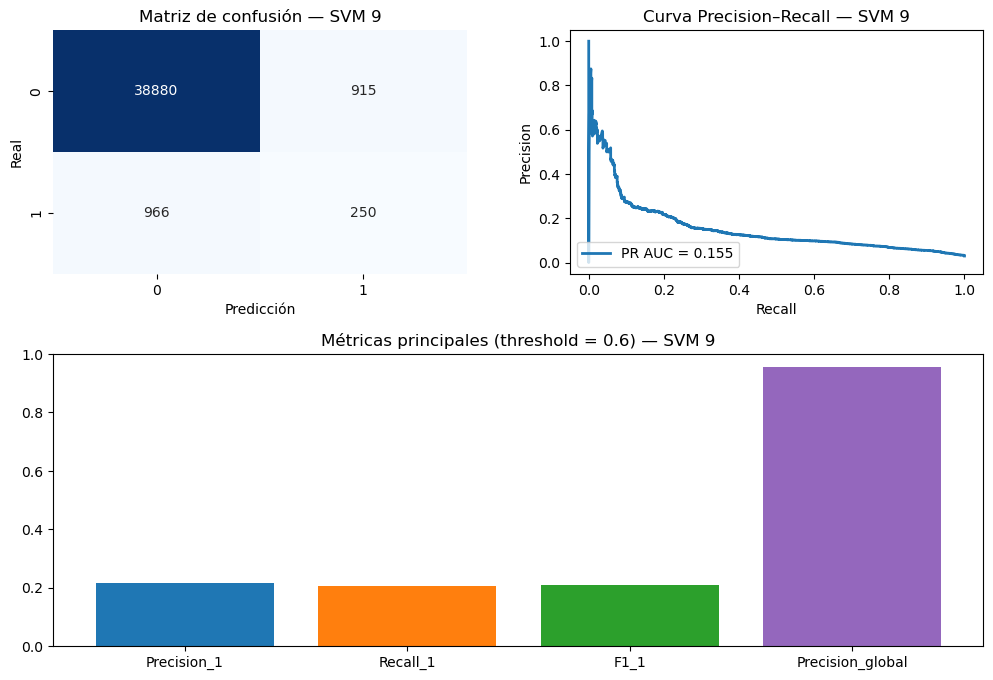

Threshold = 0.6
Precision (clase 1): 0.2146
Recall    (clase 1): 0.2056
F1        (clase 1): 0.2100
PR AUC (Average Precision): 0.1550
Precision global: 0.9541
Tiempo de entrenamiento: 536.4801 segundos


In [116]:
# Evalúa en TEST 
graficar_modelo(svm_rbf_7, X_test, y_test,
                nombre="SVM 9", threshold=0.6,train_time=train_time_SVM9)

Apesar de que el **PR AUC** bajo a 0.155, esta es la única prueba  que ha podido superar los problemas que teníamos. El **recall** y **precisión** subieron de manera significativa a los anteriores junto a la **precisión global**, alcanzando un valor de 0.95. 
Esta es la prueba más prometedora de todas, con lo que se probará el efecto de los cambios de umbrales.

In [113]:
evaluar_modelo(svm_rbf_7, X_test, y_test, nombre="SVM 9", threshold=0.3, train_time=train_time_SVM9)
evaluar_modelo(svm_rbf_7, X_test, y_test, nombre="SVM 9", threshold=0.4, train_time=train_time_SVM9)
evaluar_modelo(svm_rbf_7, X_test, y_test, nombre="SVM 9", threshold=0.5, train_time=train_time_SVM9)
evaluar_modelo(svm_rbf_7, X_test, y_test, nombre="SVM 9", threshold=0.7, train_time=train_time_SVM9)
evaluar_modelo(svm_rbf_7, X_test, y_test, nombre="SVM 9", threshold=0.8, train_time=train_time_SVM9)

=== Evaluación de SVM 9 (threshold=0.3) ===
Matriz de confusión:
 [[  277 39518]
 [    0  1216]]
Precision global: 0.0364
Precision (clase 1): 0.0299
Recall (clase 1): 1.0000
F1 (clase 1): 0.0580
PR AUC (Average Precision): 0.1550
Tiempo de entrenamiento: 536.4801 segundos
=== Evaluación de SVM 9 (threshold=0.4) ===
Matriz de confusión:
 [[  724 39071]
 [    0  1216]]
Precision global: 0.0473
Precision (clase 1): 0.0302
Recall (clase 1): 1.0000
F1 (clase 1): 0.0586
PR AUC (Average Precision): 0.1550
Tiempo de entrenamiento: 536.4801 segundos
=== Evaluación de SVM 9 (threshold=0.5) ===
Matriz de confusión:
 [[ 2677 37118]
 [    0  1216]]
Precision global: 0.0949
Precision (clase 1): 0.0317
Recall (clase 1): 1.0000
F1 (clase 1): 0.0615
PR AUC (Average Precision): 0.1550
Tiempo de entrenamiento: 536.4801 segundos
=== Evaluación de SVM 9 (threshold=0.7) ===
Matriz de confusión:
 [[39782    13]
 [ 1194    22]]
Precision global: 0.9706
Precision (clase 1): 0.6286
Recall (clase 1): 0.0181
F1 

En esta configuración los umbrales menores a 0.6 mostraron bajo rendimientos similares a los anteriores. Sim embargo, el resto mostraron buenas precisiones globales, pero el resto de métricas fueron inferiores comparados al umbral 0.6, con un recall excesivamente bajo.

### Experimento 10

In [19]:
svm_rbf_8 = SVC(
    kernel="rbf",
    C=8.0,
    gamma="scale",
    class_weight=None,   
    tol=1e-3,            
    max_iter=-1,         
    shrinking=True,
    cache_size=2000,      
    probability=False,
    random_state=42
)

# Entrenamiento

start = time.time()
svm_rbf_8.fit(X_train_res, y_train_res)
train_time_SVM10 = time.time() - start


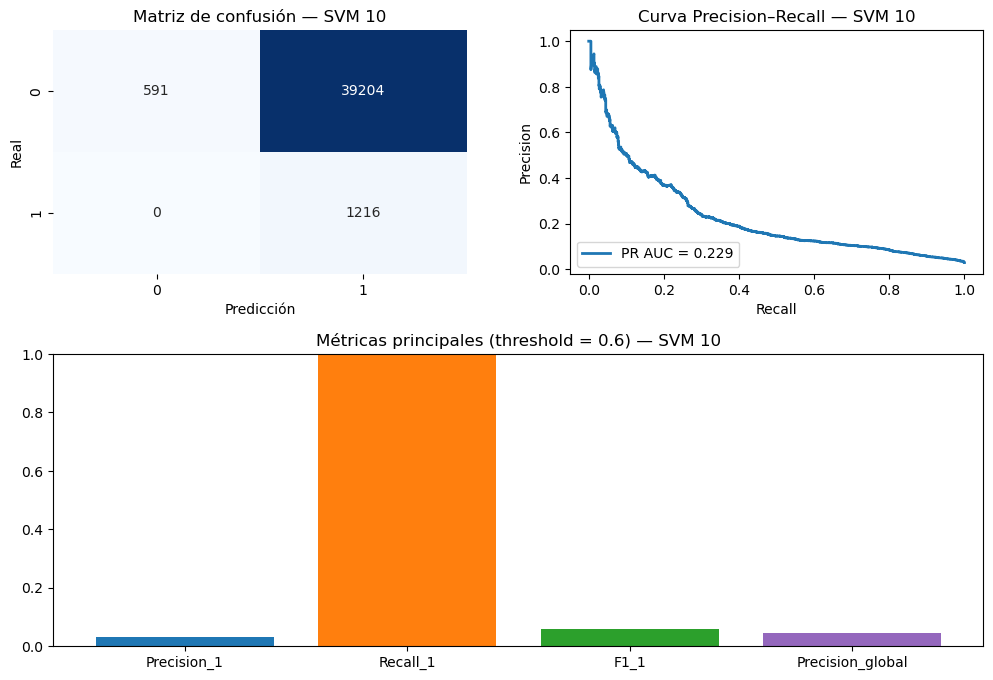

Threshold = 0.6
Precision (clase 1): 0.0301
Recall    (clase 1): 1.0000
F1        (clase 1): 0.0584
PR AUC (Average Precision): 0.2290
Precision global: 0.0441
Tiempo de entrenamiento: 1408.9996 segundos


In [20]:
# Evalúa en TEST 
graficar_modelo(svm_rbf_8, X_test, y_test,
                nombre="SVM 10", threshold=0.6,train_time=train_time_SVM10)

In [21]:
evaluar_modelo(svm_rbf_8, X_test, y_test, nombre="SVM 10", threshold=0.3, train_time=train_time_SVM10)
evaluar_modelo(svm_rbf_8, X_test, y_test, nombre="SVM 10", threshold=0.4, train_time=train_time_SVM10)
evaluar_modelo(svm_rbf_8, X_test, y_test, nombre="SVM 10", threshold=0.5, train_time=train_time_SVM10)
evaluar_modelo(svm_rbf_8, X_test, y_test, nombre="SVM 10", threshold=0.7, train_time=train_time_SVM10)
evaluar_modelo(svm_rbf_8, X_test, y_test, nombre="SVM 10", threshold=0.8, train_time=train_time_SVM10)

=== Evaluación de SVM 10 (threshold=0.3) ===
Matriz de confusión:
 [[   55 39740]
 [    0  1216]]
Precision global: 0.0310
Precision (clase 1): 0.0297
Recall (clase 1): 1.0000
F1 (clase 1): 0.0577
PR AUC (Average Precision): 0.2290
Tiempo de entrenamiento: 1408.9996 segundos
=== Evaluación de SVM 10 (threshold=0.4) ===
Matriz de confusión:
 [[  126 39669]
 [    0  1216]]
Precision global: 0.0327
Precision (clase 1): 0.0297
Recall (clase 1): 1.0000
F1 (clase 1): 0.0578
PR AUC (Average Precision): 0.2290
Tiempo de entrenamiento: 1408.9996 segundos
=== Evaluación de SVM 10 (threshold=0.5) ===
Matriz de confusión:
 [[  250 39545]
 [    0  1216]]
Precision global: 0.0357
Precision (clase 1): 0.0298
Recall (clase 1): 1.0000
F1 (clase 1): 0.0579
PR AUC (Average Precision): 0.2290
Tiempo de entrenamiento: 1408.9996 segundos
=== Evaluación de SVM 10 (threshold=0.7) ===
Matriz de confusión:
 [[ 1850 37945]
 [    2  1214]]
Precision global: 0.0747
Precision (clase 1): 0.0310
Recall (clase 1): 0.9

##  K Nearest Neighbours 

#### Experimento 1

Para esta configuración incial se usará un número de vecinos(**n_neighbors**) igual a 5, junto con la métrica de distancia euclidiana (**metric = "minkowski", p = 2**) y se habilitará el uso de todos los núcleos disponibles (**n_jobs = -1**). 

In [25]:
knn = KNeighborsClassifier(
    n_neighbors=5,       
    weights="distance",  
    metric="minkowski", 
    p=2,
    n_jobs=-1           
)

# Entrenamiento

start = time.time()
knn.fit(X_train_res, y_train_res)
train_time_KNN1 = time.time() - start

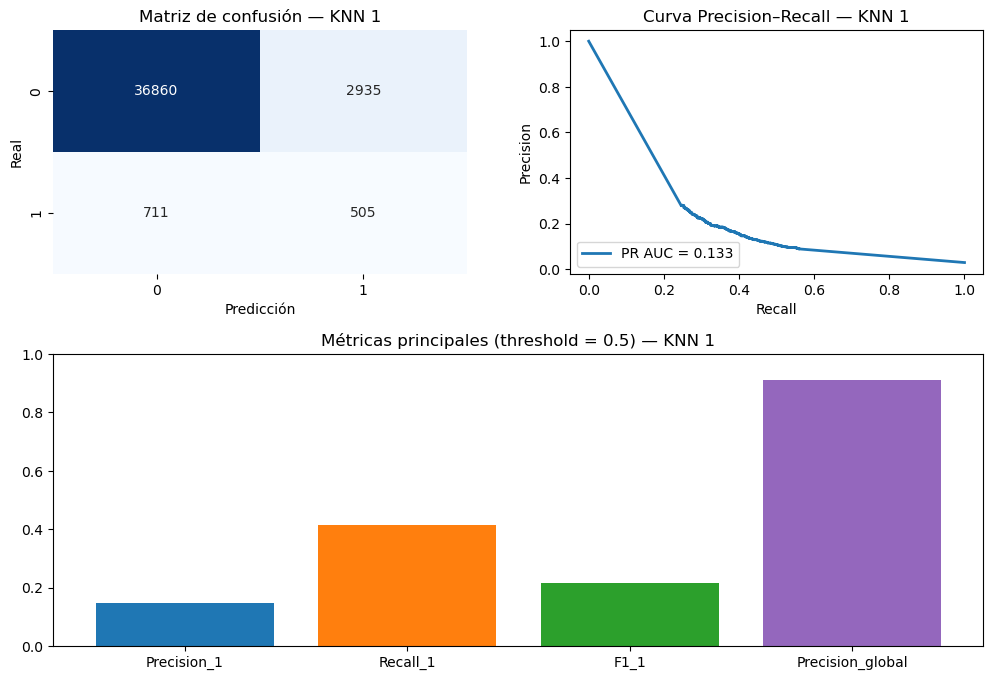

Threshold = 0.5
Precision (clase 1): 0.1468
Recall    (clase 1): 0.4153
F1        (clase 1): 0.2169
PR AUC (Average Precision): 0.1327
Precision global: 0.9111
Tiempo de entrenamiento: 0.3335 segundos


In [26]:
graficar_modelo(knn, X_test, y_test, nombre="KNN 1", threshold=0.5, train_time=train_time_KNN1)


Se observa una mejora respecto al anterior algoritmo con mejor balance de **recall** y **precisión**, y una buena **precisión global**, en un tiempo ínfimo. No obstante, el **PR AUC** todavia deja bastante que desear.
Por ello se probarán distintas configuraciones para ver el alcance de este modelo

#### Experimento 2


Ahora se probará aumentar el número de vecinos a **11** para ver si al tener en cuenta más muestras cercanas el modelo se vuelve más estable y reduce errores en la clasificación.

In [27]:
knn2 = KNeighborsClassifier(
    n_neighbors=11,      
    weights="distance",  
    metric="minkowski",
    p=2,
    n_jobs=-1
)

# Entrenamiento

start = time.time()
knn2.fit(X_train_res, y_train_res)
train_time_KNN2 = time.time() - start

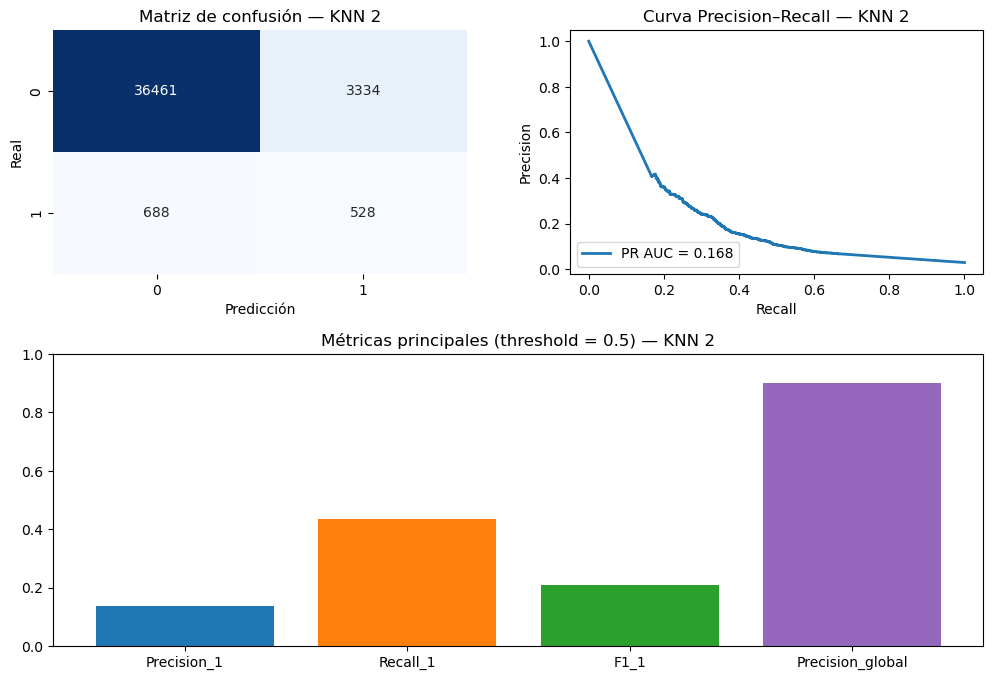

Threshold = 0.5
Precision (clase 1): 0.1367
Recall    (clase 1): 0.4342
F1        (clase 1): 0.2080
PR AUC (Average Precision): 0.1685
Precision global: 0.9019
Tiempo de entrenamiento: 0.2923 segundos


In [28]:
graficar_modelo(knn2, X_test, y_test, nombre="KNN 2", threshold=0.5, train_time=train_time_KNN2)


Como se puede ver, aumentar el número de vecino tuvo cierto impacto positvo en el modelo elevando su **PR AUC** a 0.168, pero manteniendo similaridad en el resto de métricas con el anterior. 

#### Experimento 3


En este nuevo experimento se aumenta el número de vecinos a **21** y se cambia la métrica de distancia a **Manhattan (p = 1)**. Esto con el objetivo de aumentar la estabilidad y comprobar si la otra métrica de distancia mejora la precisión y recall

In [29]:
knn3 = KNeighborsClassifier(
    n_neighbors=21,      
    weights="distance",  
    metric="minkowski",  
    p=1,                 
    n_jobs=-1
)

# Entrenamiento

start = time.time()
knn3.fit(X_train_res, y_train_res)
train_time_KNN3 = time.time() - start

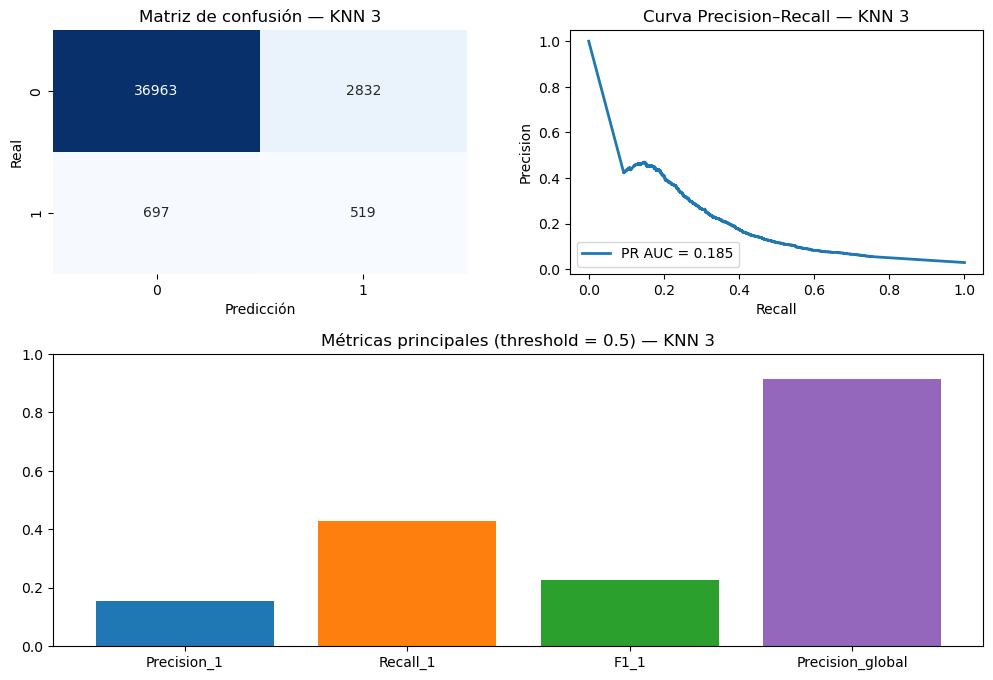

Threshold = 0.5
Precision (clase 1): 0.1549
Recall    (clase 1): 0.4268
F1        (clase 1): 0.2273
PR AUC (Average Precision): 0.1850
Precision global: 0.9139
Tiempo de entrenamiento: 0.3166 segundos



In [111]:
graficar_modelo(knn3, X_test, y_test, nombre="KNN 3", threshold=0.5, train_time=train_time_KNN3)

Se observa otra mejora de su capacidad discriminativa, **PR AUC = 0.185**, y en el F1. Aumentar el número de vecinos y cambiar la métrica a Manhattan tuvo un impacto positivo en el modelo.

#### Experimento 4

En este experimento se incrementa el número de vecinos a **51** y se cambia la ponderación a **"uniform"**, de modo que todos los vecinos contribuyen por igual a la decisión.

In [31]:
knn4 = KNeighborsClassifier(
    n_neighbors=51,      
    weights="uniform", 
    metric="minkowski",  
    p=1,                 
    n_jobs=-1
)

# Entrenamiento

start = time.time()
knn4.fit(X_train_res, y_train_res)
train_time_KNN4 = time.time() - start

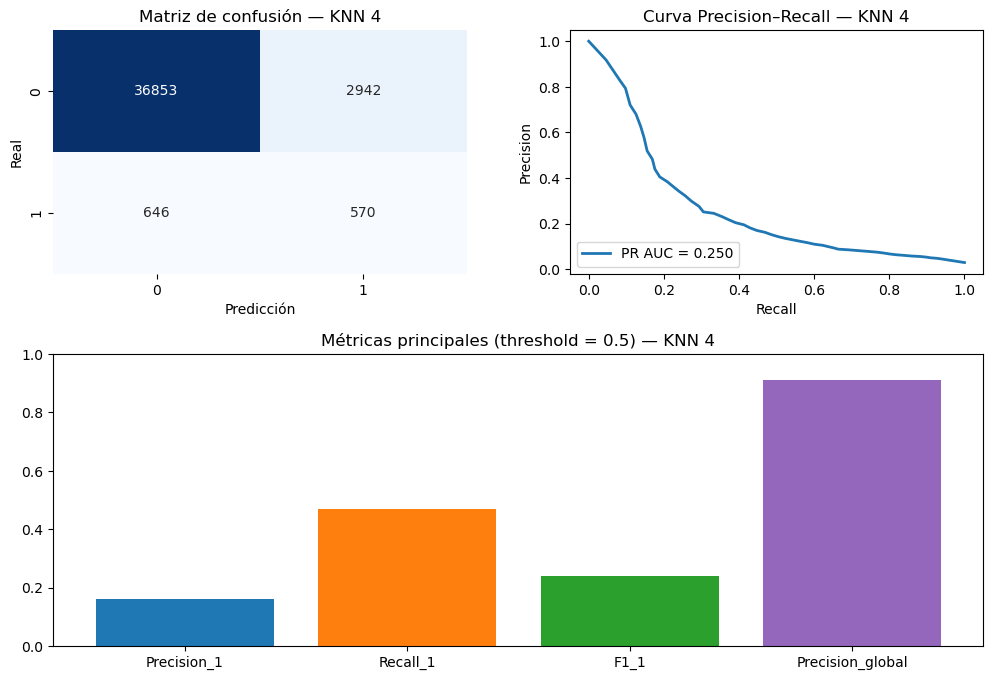

Threshold = 0.5
Precision (clase 1): 0.1623
Recall    (clase 1): 0.4688
F1        (clase 1): 0.2411
PR AUC (Average Precision): 0.2504
Precision global: 0.9125
Tiempo de entrenamiento: 0.3254 segundos


In [32]:
graficar_modelo(knn4, X_test, y_test, nombre="KNN 4", threshold=0.5, train_time=train_time_KNN4)


El cambio a una ponderación uniforme y volver a aumentar sus vecinos han tenido una mejora significativa, alcanzando un **PR AUC** de 0.250 y mejorando el F1. Esto puede deberser que al tener más vecinos y darles el mismo peso, el modelo, reduce el efecto de ruido y de los valores atípicos, logrando decisiones más estables.

#### Experimento 5

Manteniendo el resto de parámetros iguales, duplicamos el número de vecinos hasta llegar a **101** para comprobar si aun sigue teniendo un efecto positivo en este dataset.

In [33]:
knn5 = KNeighborsClassifier(
    n_neighbors=101,      
    weights="uniform",   
    metric="minkowski",  
    p=1,                
    n_jobs=-1
)

# Entrenamiento

start = time.time()
knn5.fit(X_train_res, y_train_res)
train_time_KNN5 = time.time() - start

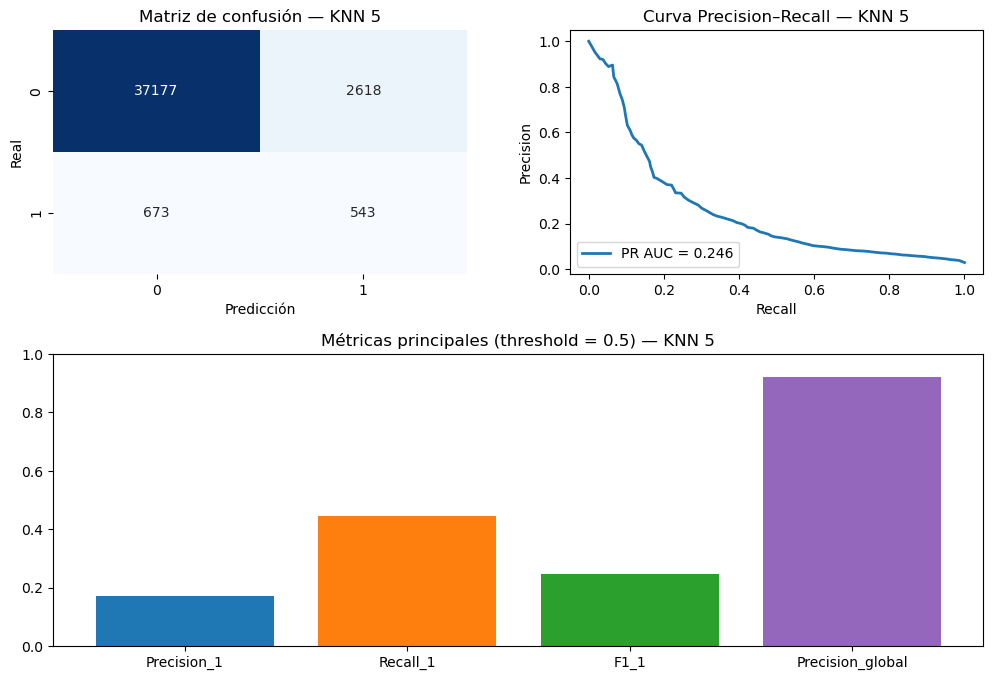

Threshold = 0.5
Precision (clase 1): 0.1718
Recall    (clase 1): 0.4465
F1        (clase 1): 0.2481
PR AUC (Average Precision): 0.2460
Precision global: 0.9198
Tiempo de entrenamiento: 0.3687 segundos


In [34]:
graficar_modelo(knn5, X_test, y_test, nombre="KNN 5", threshold=0.5, train_time=train_time_KNN5)


Es un resultado muy similar al anterior, pero bajando ligeramente el **PR AUC** a **0.246** a cambio de una mínima mejora de F1. Esto parece indicar que cambiar el número de vecinos no producirá mejoras significativas.

#### Experimento 6


Volvemos a al valor **51** para los vecinos, pero en este caso cambiamos la ponderación a por **distancia** para que los vecinos mas cercanos tenga mayor influencia.

In [37]:
knn6 = KNeighborsClassifier(
    n_neighbors=51,    
    weights="distance",   
    metric="minkowski",  
    p=1,               
    n_jobs=-1
)

# Entrenamiento

start = time.time()
knn6.fit(X_train_res, y_train_res)
train_time_KNN6 = time.time() - start

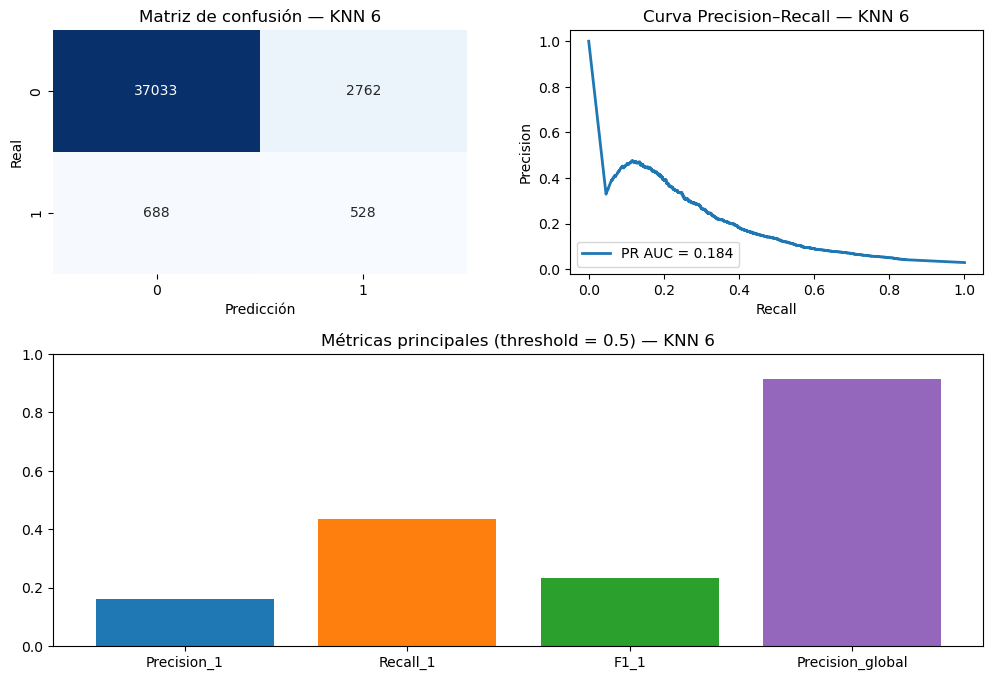

Threshold = 0.5
Precision (clase 1): 0.1605
Recall    (clase 1): 0.4342
F1        (clase 1): 0.2344
PR AUC (Average Precision): 0.1838
Precision global: 0.9159
Tiempo de entrenamiento: 0.3154 segundos


In [38]:
graficar_modelo(knn6, X_test, y_test, nombre="KNN 6", threshold=0.5, train_time=train_time_KNN6)


Aunque podría haber parecido beneficioso, no proporciono ninguna mejora e incluso decremento el **PR AUC** a **0.184** y el F1. Por lo que se volverá a la antigua ponderación.

#### Experimento 7

Para este experimento se probó cambiar la métrica a **chebyshev**, debido a que funciona de forma diferente a las anteriores: esta métrica considera únicamente la mayor diferencia entre las características de dos muestras, lo que puede influir en cómo el modelo mide la similitud entre ellas.

In [39]:
knn7 = KNeighborsClassifier(
    n_neighbors=51,      
    weights="uniform",   
    metric="chebyshev",  
    n_jobs=-1
)

# Entrenamiento

start = time.time()
knn7.fit(X_train_res, y_train_res)
train_time_KNN7 = time.time() - start

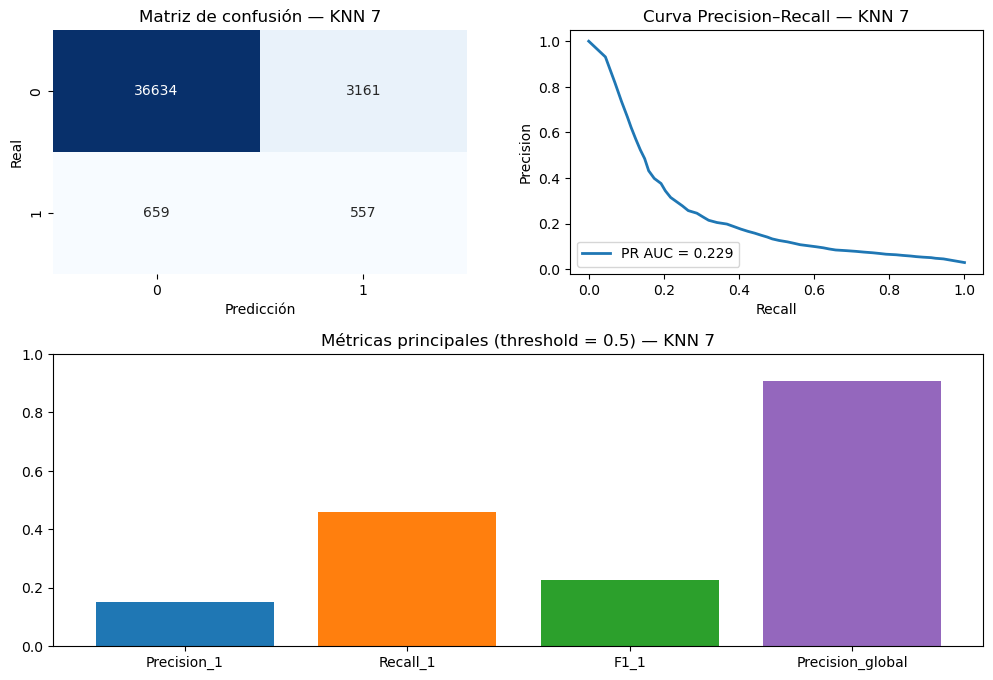

Threshold = 0.5
Precision (clase 1): 0.1498
Recall    (clase 1): 0.4581
F1        (clase 1): 0.2258
PR AUC (Average Precision): 0.2289
Precision global: 0.9069
Tiempo de entrenamiento: 0.3168 segundos


In [40]:
graficar_modelo(knn7, X_test, y_test, nombre="KNN 7", threshold=0.5, train_time=train_time_KNN7)


El **PR AUC** mantuvo un rendimiento intermedio con un valor de **0.229** y el resto mantuvieron valores similares. Con lo que no da ninguna razón para matener esta configuración

Desde el experimento 4, el resto de pruebas no han dado ningun resultado significativo, e incluso empeoraron su capacidad discriminativa en cierta medida. Por lo que se finalizarán las pruebas de este algortimo buscando el umbral que mejor compromiso entre recall y precisión proporcione.

In [45]:
evaluar_modelo(knn4, X_test, y_test, nombre="KNN 4", threshold=0.3, train_time=train_time_KNN4)
evaluar_modelo(knn4, X_test, y_test, nombre="KNN 4", threshold=0.4, train_time=train_time_KNN4)
evaluar_modelo(knn4, X_test, y_test, nombre="KNN 4", threshold=0.5, train_time=train_time_KNN4)
evaluar_modelo(knn4, X_test, y_test, nombre="KNN 4", threshold=0.6, train_time=train_time_KNN4)
evaluar_modelo(knn4, X_test, y_test, nombre="KNN 4", threshold=0.7, train_time=train_time_KNN4)
evaluar_modelo(knn4, X_test, y_test, nombre="KNN 4", threshold=0.8, train_time=train_time_KNN4)

=== Evaluación de KNN 4 (threshold=0.3) ===
Matriz de confusión:
 [[32129  7666]
 [  423   793]]
Precision global: 0.8028
Precision (clase 1): 0.0937
Recall (clase 1): 0.6521
F1 (clase 1): 0.1639
PR AUC (Average Precision): 0.2504
Tiempo de entrenamiento: 0.3254 segundos 

=== Evaluación de KNN 4 (threshold=0.4) ===
Matriz de confusión:
 [[34892  4903]
 [  531   685]]
Precision global: 0.8675
Precision (clase 1): 0.1226
Recall (clase 1): 0.5633
F1 (clase 1): 0.2014
PR AUC (Average Precision): 0.2504
Tiempo de entrenamiento: 0.3254 segundos 

=== Evaluación de KNN 4 (threshold=0.5) ===
Matriz de confusión:
 [[36853  2942]
 [  646   570]]
Precision global: 0.9125
Precision (clase 1): 0.1623
Recall (clase 1): 0.4688
F1 (clase 1): 0.2411
PR AUC (Average Precision): 0.2504
Tiempo de entrenamiento: 0.3254 segundos 

=== Evaluación de KNN 4 (threshold=0.6) ===
Matriz de confusión:
 [[38164  1631]
 [  763   453]]
Precision global: 0.9416
Precision (clase 1): 0.2174
Recall (clase 1): 0.3725
F1 

## Random Forest

En esta primera prueba se emplea un modelo con **300 árboles**, sin límite de profundidad (**max_depth = None**), y con restricciones moderadas en el crecimiento de los nodos (**min_samples_split = 10, min_samples_leaf = 5**) para evitar el sobreajuste.

In [46]:
rf1 = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1   
)

# Entrenamiento

start = time.time()
rf1.fit(X_train_res, y_train_res)
train_time_RF1 = time.time() - start


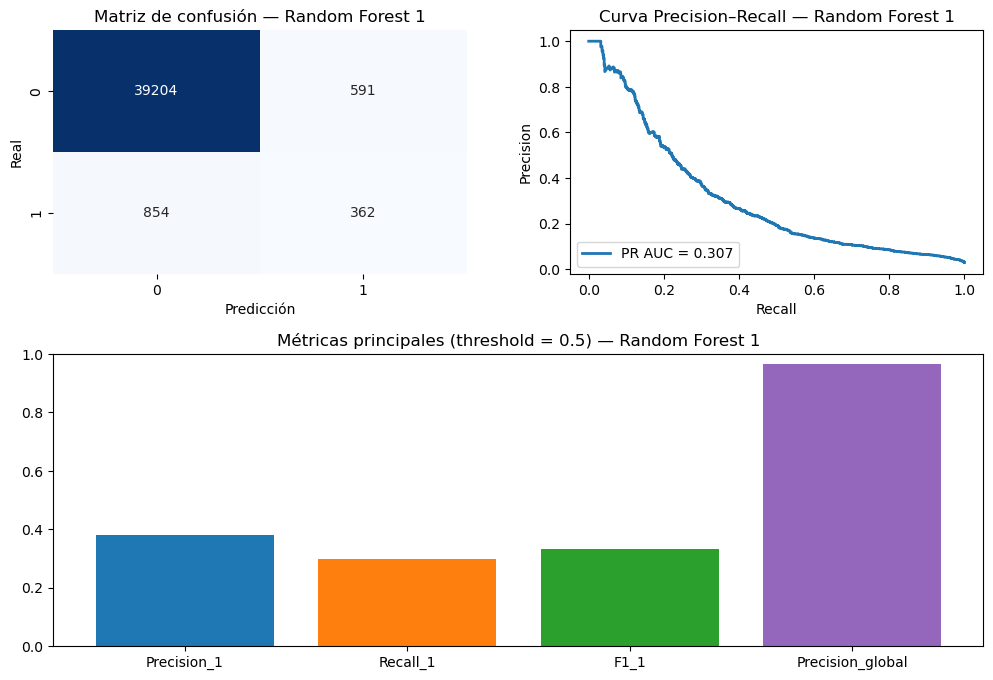

Threshold = 0.5
Precision (clase 1): 0.3799
Recall    (clase 1): 0.2977
F1        (clase 1): 0.3338
PR AUC (Average Precision): 0.3073
Precision global: 0.9648
Tiempo de entrenamiento: 11.3195 segundos



In [57]:
# Evalúa en TEST
graficar_modelo(rf1, X_test, y_test, nombre="Random Forest 1", train_time=train_time_RF1)

Esta prueba ha conseguido un redimiento bastante superior al resto de los los algoritmos anteriores. Obteniendo un **F1 de 0.33** y **PR AUC de 0.31**. Además de una precisión global (**96.5%**) bastante alta, el tiempo de entrenamiento es bastante bueno (**≈11s**). En conjunto, este algortimo parece prometedor para este tipo de problemas.

#### Experimento 2

Ahora se incrementará el número de árboles a **1000** para evaluar si un mayor número de estimadores mejora la capacidad del modelo para generalizar. Además, se ajustan los parámetros internos (**min_samples_leaf = 2**) para capturar patrones más fino en la clase minoritaria.

In [48]:
rf2 = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1     
)

# Entrenamiento

start = time.time()
rf2.fit(X_train_res, y_train_res)
train_time_RF2 = time.time() - start


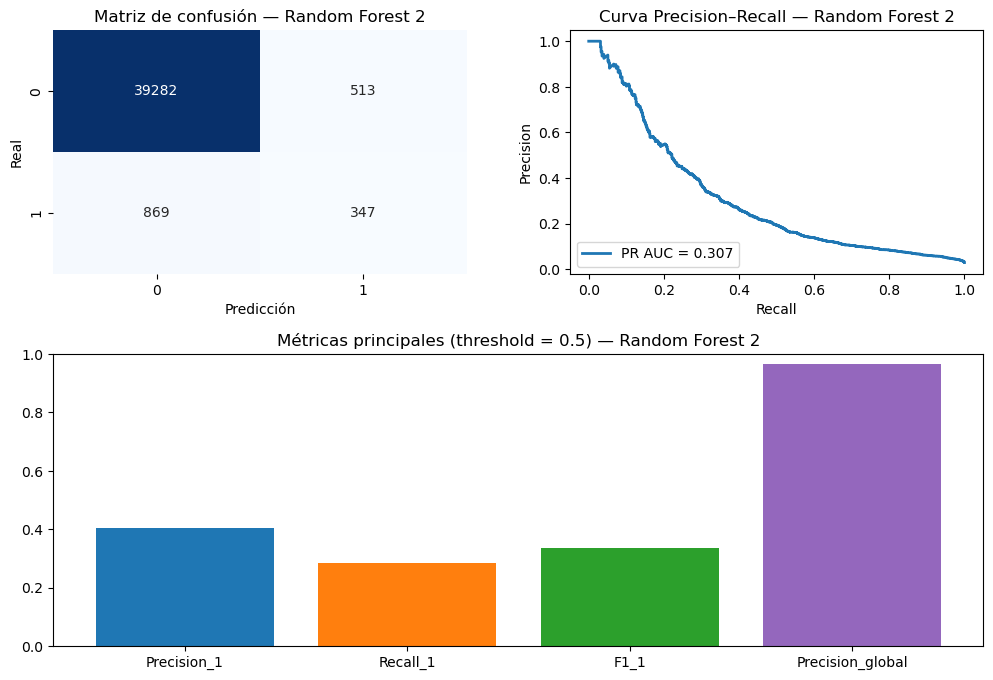

Threshold = 0.5
Precision (clase 1): 0.4035
Recall    (clase 1): 0.2854
F1        (clase 1): 0.3343
PR AUC (Average Precision): 0.3069
Precision global: 0.9663
Tiempo de entrenamiento: 37.0257 segundos



In [58]:
# Evalúa en TEST
graficar_modelo(rf2, X_test, y_test, nombre="Random Forest 2", train_time=train_time_RF2)

Los resultados se matuvieron prácticamente igual tanto el **PR AUC** como el resto de métricas. Sin embargo, tiempo de entrenamiento subió llegando triplicar el tiempo anterior. Esto podría ser indicio que ya encontramos un buen modelo con el primer experimento.
    

#### Experimento 3

En esta pequeña prueba solamente se cambio el número de árboles a un valor (**300**) , maneteniendo el resto de parámetros de anterior.

In [114]:
rf3 = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento

start = time.time()
rf3.fit(X_train_res, y_train_res)
train_time_RF3 = time.time() - start

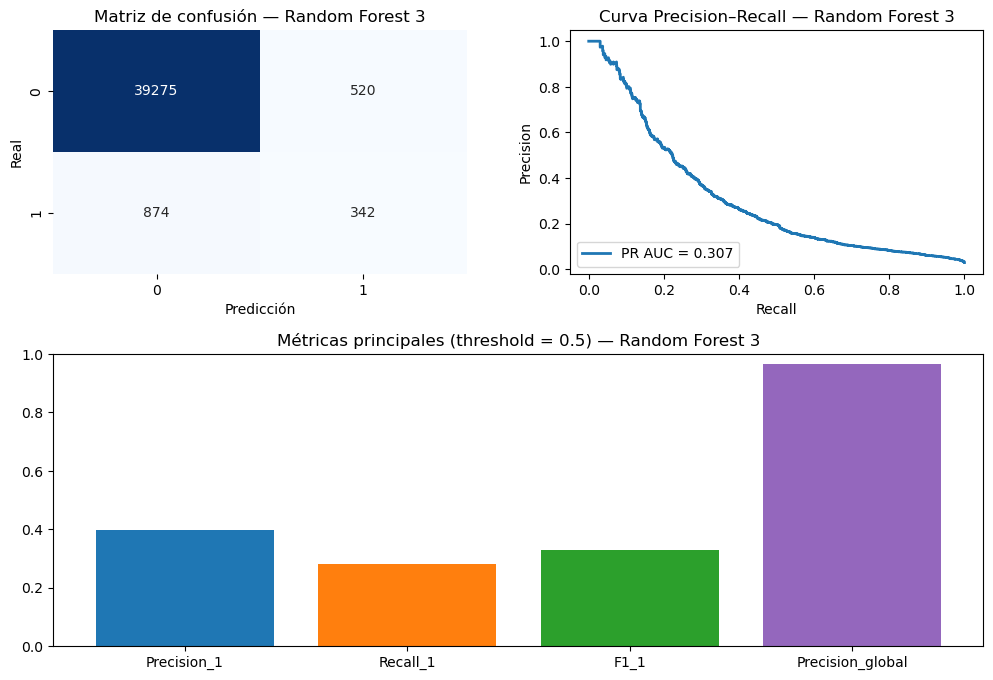

Threshold = 0.5
Precision (clase 1): 0.3968
Recall    (clase 1): 0.2812
F1        (clase 1): 0.3292
PR AUC (Average Precision): 0.3073
Precision global: 0.9660
Tiempo de entrenamiento: 10.8460 segundos



In [115]:
# Evalúa en TEST
graficar_modelo(rf3, X_test, y_test, nombre="Random Forest 3", train_time=train_time_RF3)

Igualmente dio un resultado muy similar al primero en todo sentido, exceptuando una muy ligera baja en F1. Por ello, probaremos con un cambio más grande en busca de rendimientos distintos.

#### Experimento 4

En este caso se experimento con un mayor número de árboles (**1500**) y hojas mínimas (**min_samples_split = 2 ,min_samples_leaf = 1**). También se usó **max_features = "sqrt"** para introducir más diversidad en los árboles.

In [53]:
rf4 = RandomForestClassifier(
    n_estimators=1500,       
    max_depth=None,          
    min_samples_split=2,     
    min_samples_leaf=1,      
    max_features="sqrt",     
    random_state=42,
    n_jobs=-1               
)

# Entrenamiento

start = time.time()
rf4.fit(X_train_res, y_train_res)
train_time_RF4 = time.time() - start

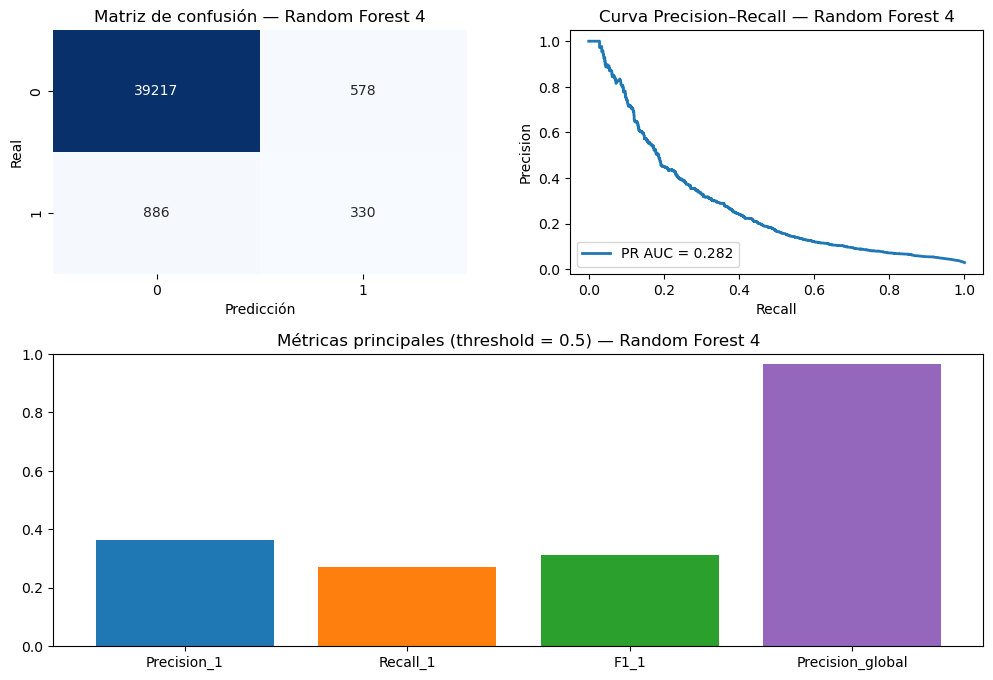

Threshold = 0.5
Precision (clase 1): 0.3634
Recall    (clase 1): 0.2714
F1        (clase 1): 0.3107
PR AUC (Average Precision): 0.2815
Precision global: 0.9643
Tiempo de entrenamiento: 61.0488 segundos



In [60]:
# Evalúa en TEST
graficar_modelo(rf4, X_test, y_test, nombre="Random Forest 4", train_time=train_time_RF4)

La salida fue peor, con un **PR AUC de 0.282** y menor F1. Lo que indica que el modelo se sobreajustó y perdió capacidad de generalización en test. Además de que el tiempo de entrenamiento subió de forma considerable llegando a sextuplicarse.

#### Experimento 5

En este quinto experimento con Random Forest se mantuvo una configuración muy similar a la del RF3, que había mostrado el mejor equilibrio hasta ahora, pero se incorporó una diferencia clave: el uso de class_weight="balanced_subsample". Esta opción permite que cada árbol del bosque ajuste automáticamente los pesos de las clases en función de la proporción que tenga en su muestra de bootstrap, lo que refuerza la atención sobre la clase minoritaria en cada iteración. El objetivo de esta variante es comprobar si, además del oversampling aplicado en el conjunto de entrenamiento, un ajuste dinámico de pesos dentro del propio modelo puede mejorar la capacidad de detección de phishing y, en consecuencia, elevar métricas críticas como el recall y el PR AUC.

En esta prueba se mantuvo la configuración del experimento 3, pero se añadió el parámetro **class_weight = "balanced_subsample"**, para ajustar el peso de las clases dentro de cada árbol del bosque. Esto con el fin se encontrar algún efecto positivo.

In [55]:
rf5 = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=2,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)

# Entrenamiento

start = time.time()
rf5.fit(X_train_res, y_train_res)
train_time_RF5 = time.time() - start

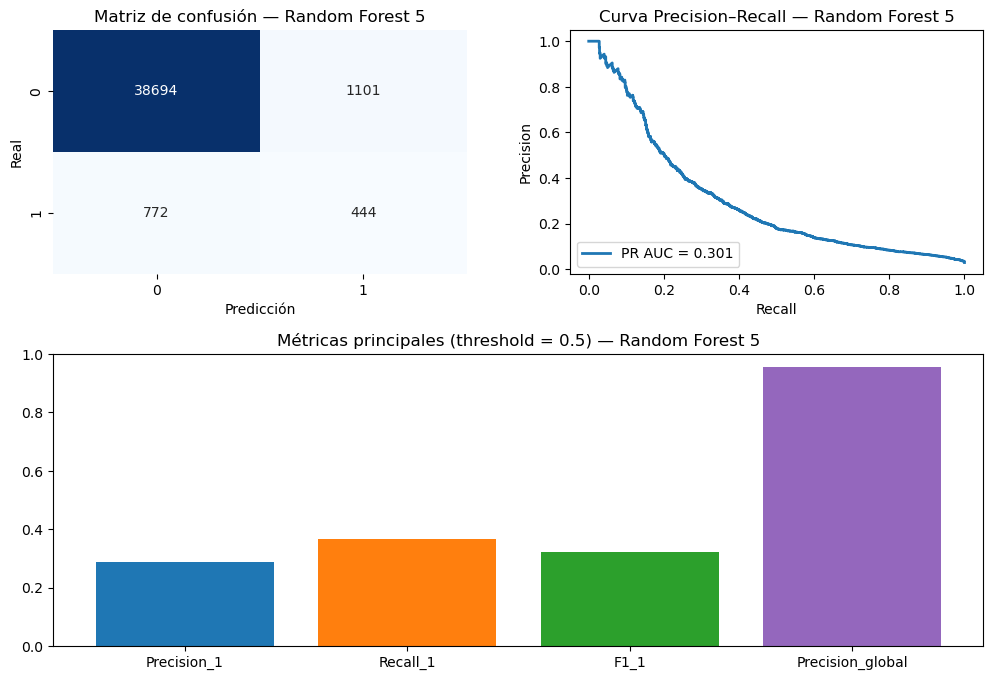

Threshold = 0.5
Precision (clase 1): 0.2874
Recall    (clase 1): 0.3651
F1        (clase 1): 0.3216
PR AUC (Average Precision): 0.3007
Precision global: 0.9543
Tiempo de entrenamiento: 54.9037 segundos



In [61]:
# Evalúa en TEST
graficar_modelo(rf5, X_test, y_test, nombre="Random Forest 5", train_time=train_time_RF5)

Las métricas fueron bastante parecidas, solamente recalcando que el tiempo de entrenamiento fue uno de los mayores hasta el momento. Por lo que no aporto nada significativo.

#### Experimento 6

En este ultimo experimento se quiso probar un cambio más brusco. Por lo que, se limitó la **profundidad máxima** de los árboles a **8** niveles y se ajustaron los parámetros de división (**min_samples_split = 6, min_samples_leaf = 3**), además de aumentar el **número de árboles a 2000** para compensar la menor complejidad individual. Estos cambios se hicieron con el objetivo obtener más estabilidad y diversidad, reducir el overfitting y ganar sensibilidad

In [62]:
rf6 = RandomForestClassifier(
    n_estimators=2000,   
    max_depth=8,        
    min_samples_split=6,
    min_samples_leaf=3, 
    random_state=42,
    n_jobs=-1
)

# Entrenamiento

start = time.time()
rf6.fit(X_train_res, y_train_res)
train_time_RF6 = time.time() - start

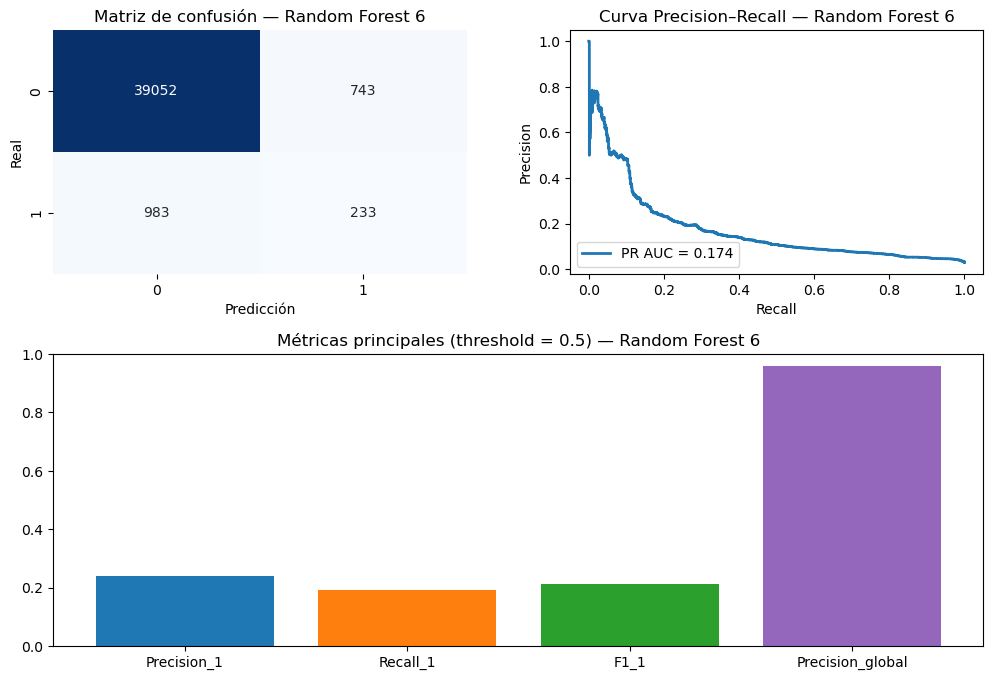

Threshold = 0.5
Precision (clase 1): 0.2387
Recall    (clase 1): 0.1916
F1        (clase 1): 0.2126
PR AUC (Average Precision): 0.1743
Precision global: 0.9579
Tiempo de entrenamiento: 44.7602 segundos



In [63]:
# Evalúa en TEST
graficar_modelo(rf6, X_test, y_test, nombre="Random Forest 6", threshold=0.5, train_time=train_time_RF6)

Desgraciadamente, este fue el modelo con menor capacidad predictiva, **PR AUC de 0.174** y una **F1 de 0.2126**. Demostrando que una regularización excesiva reduce el rendimiento en este caso.

Como después de todas esta pruebas no se encontró ninguna configuración que supere de forma significativa el primer experimento. Dentendremos las pruebas y buscaremos el umbral que mejor balance entre recall y precisión nos pueda dar.

In [64]:
evaluar_modelo(rf1, X_test, y_test, nombre="Random Forest 1", threshold=0.4, train_time=train_time_RF1)
evaluar_modelo(rf1, X_test, y_test, nombre="Random Forest 1", train_time=train_time_RF1)
evaluar_modelo(rf1, X_test, y_test, nombre="Random Forest 1", threshold=0.6, train_time=train_time_RF1)
evaluar_modelo(rf1, X_test, y_test, nombre="Random Forest 1", threshold=0.7, train_time=train_time_RF1)
evaluar_modelo(rf1, X_test, y_test, nombre="Random Forest 1", threshold=0.8, train_time=train_time_RF1)


=== Evaluación de Random Forest 1 (threshold=0.4) ===
Matriz de confusión:
 [[38613  1182]
 [  753   463]]
Precision global: 0.9528
Precision (clase 1): 0.2815
Recall (clase 1): 0.3808
F1 (clase 1): 0.3237
PR AUC (Average Precision): 0.3073
Tiempo de entrenamiento: 11.3195 segundos 

=== Evaluación de Random Forest 1 (threshold=0.5) ===
Matriz de confusión:
 [[39204   591]
 [  854   362]]
Precision global: 0.9648
Precision (clase 1): 0.3799
Recall (clase 1): 0.2977
F1 (clase 1): 0.3338
PR AUC (Average Precision): 0.3073
Tiempo de entrenamiento: 11.3195 segundos 

=== Evaluación de Random Forest 1 (threshold=0.6) ===
Matriz de confusión:
 [[39533   262]
 [  947   269]]
Precision global: 0.9705
Precision (clase 1): 0.5066
Recall (clase 1): 0.2212
F1 (clase 1): 0.3080
PR AUC (Average Precision): 0.3073
Tiempo de entrenamiento: 11.3195 segundos 

=== Evaluación de Random Forest 1 (threshold=0.7) ===
Matriz de confusión:
 [[39694   101]
 [ 1035   181]]
Precision global: 0.9723
Precision (cl

## Xgboost

### Experimento 1




En este primer experimento se configuró la optimización sobre PR AUC (**eval_metric = "aucpr"**), con **1000 árboles** y una **tasa de aprendizaje** moderada (**learning_rate = 0.05**). Los hiperparámetros de regularización y muestreo (**max_depth=6**, **min_child_weight=5**, **subsample=0.8**, **colsample_bytree=0.8**) buscan un **buen equilibrio entre precisión y generalización**, evitando sobreajuste.  

In [ ]:
xgb_simple = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",     # optimizamos PR AUC
    n_estimators=1000,       # nº de árboles
    learning_rate=0.05,      # como "eta"
    max_depth=6,             # profundidad de los árboles
    min_child_weight=5,      # mínimo peso de nodo
    subsample=0.8,           # muestreo filas
    colsample_bytree=0.8,    # muestreo columnas
    random_state=42,
    n_jobs=-1,
    verbosity=1

In [116]:
xgb1 = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",     
    n_estimators=1000,      
    learning_rate=0.05,      
    max_depth=6,             
    min_child_weight=5,      
    subsample=0.8,           
    colsample_bytree=0.8,    
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

# Entrenamiento

start = time.time()
xgb1.fit(X_train_res, y_train_res)
train_time_XGB1 = time.time() - start

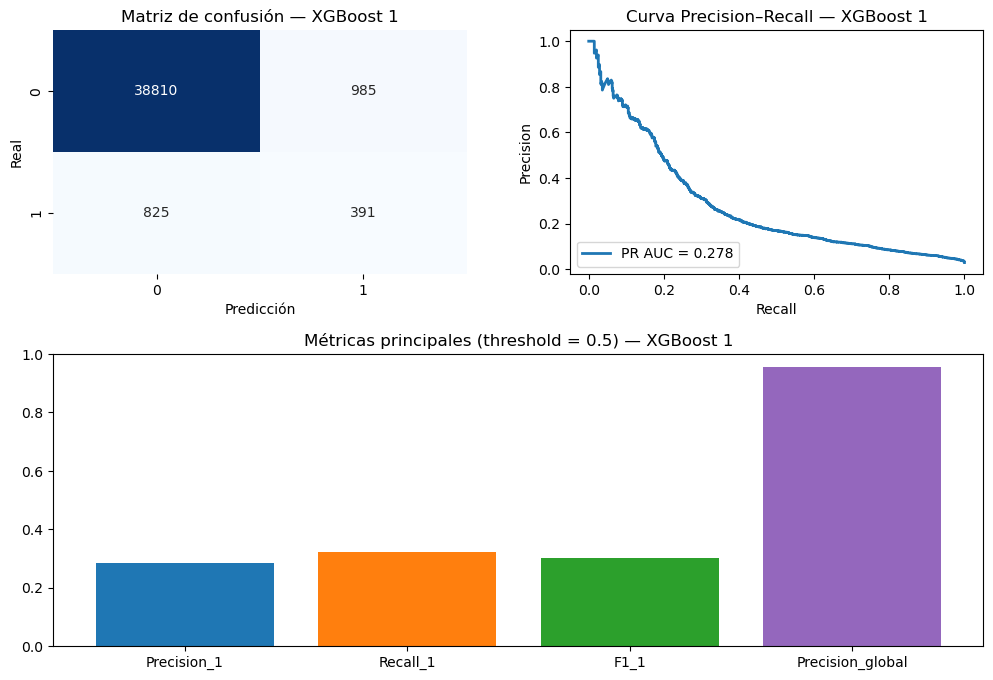

Threshold = 0.5
Precision (clase 1): 0.2842
Recall    (clase 1): 0.3215
F1        (clase 1): 0.3017
PR AUC (Average Precision): 0.2782
Precision global: 0.9559
Tiempo de entrenamiento: 6.0869 segundos



In [117]:
# Evaluamos en test
graficar_modelo(xgb1, X_test, y_test, nombre="XGBoost 1", threshold=0.5, train_time=train_time_XGB1)

Esta primera salida nos proporciona un rendimiento equilibrado, con **F1 de 0.30** y un **PR AUC de 0.278**, valores cercanos a los obtenidos en Random Forest, pero con un **tiempo** de entrenamiento menor (**≈6 s**). Esto demuestra que XGBoost ofrece un punto de partida bastante prometedor desde el inicio.

### Experimento 2

En esta prueba se incrementó la profundidad máxima de los árboles (**max_depth=8**) para capturar interacciones más complejas, se añadió regularización L1 suave (**reg_alpha=0.5**) para evitar el sobreajuste y se amplió el número de árboles (**n_estimators=1200**).

In [69]:
xgb2 = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",    
    n_estimators=1200,      
    learning_rate=0.05,   
    max_depth=8,           
    min_child_weight=5, 
    subsample=0.8,         
    colsample_bytree=0.8,  
    reg_alpha=0.5,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)


start = time.time()
xgb2.fit(X_train_res, y_train_res)
train_time_XGB2 = time.time() - start

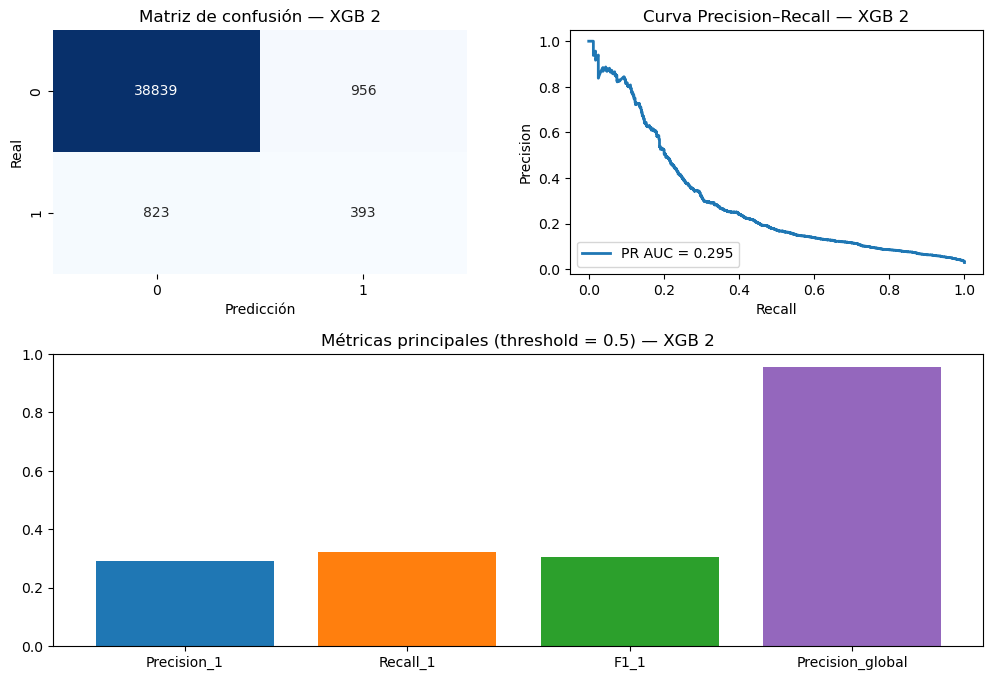

Threshold = 0.5
Precision (clase 1): 0.2913
Recall    (clase 1): 0.3232
F1        (clase 1): 0.3064
PR AUC (Average Precision): 0.2945
Precision global: 0.9566
Tiempo de entrenamiento: 6.2398 segundos



In [70]:
# Evaluamos en test
graficar_modelo(xgb2, X_test, y_test, nombre="XGB 2", threshold=0.5, train_time=train_time_XGB2)


En este segundo experimento, se observa una mejora general en el rendimiento, alcanzando un **PR AUC de 0.295** y un **F1 de 0.31**, con un equilibrio sólido entre precisión y recall.
El aumento de profundidad y la ligera regularización parecen haber ayudado al modelo a captar mejor patrones relevantes sin sobreajustar, manteniendo un tiempo de entrenamieno similar.

### Experimento 3

En esta caso se redujo la **profundidad** máxima de los árboles (**max_depth=4**) y se incrementó el **peso** mínimo por nodo (**min_child_weight=7**) para hacer el modelo menos propenso al sobreajuste.
También se añadió un término de regularización **gamma** (**1.0**) que penaliza divisiones innecesarias, y se aumentaron los parámetros de muestreo (**subsample=0.9, colsample_bytree=0.9**) para fomentar una mayor diversidad entre los árboles.
Además, se aplicó una combinación de regularización L1 y L2 (**reg_alpha=0.5, reg_lambda=1.5**) y se utilizó el método de construcción **"hist"**, para mayor eficiencia.
Todo esto con el objetivo de obtener un modelo más robusto y generalizable.

In [71]:
xgb3 = XGBClassifier(
    objective="binary:logistic", 
    eval_metric="aucpr",
    n_estimators=1200, 
    learning_rate=0.05,
    max_depth=4,           
    min_child_weight=7,     
    gamma=1.0,              
    subsample=0.9, 
    colsample_bytree=0.9,
    reg_alpha=0.5,         
    reg_lambda=1.5,        
    tree_method="hist", 
    random_state=42, 
    n_jobs=-1
)


start = time.time()
xgb3.fit(X_train_res, y_train_res)
train_time_XGB3 = time.time() - start


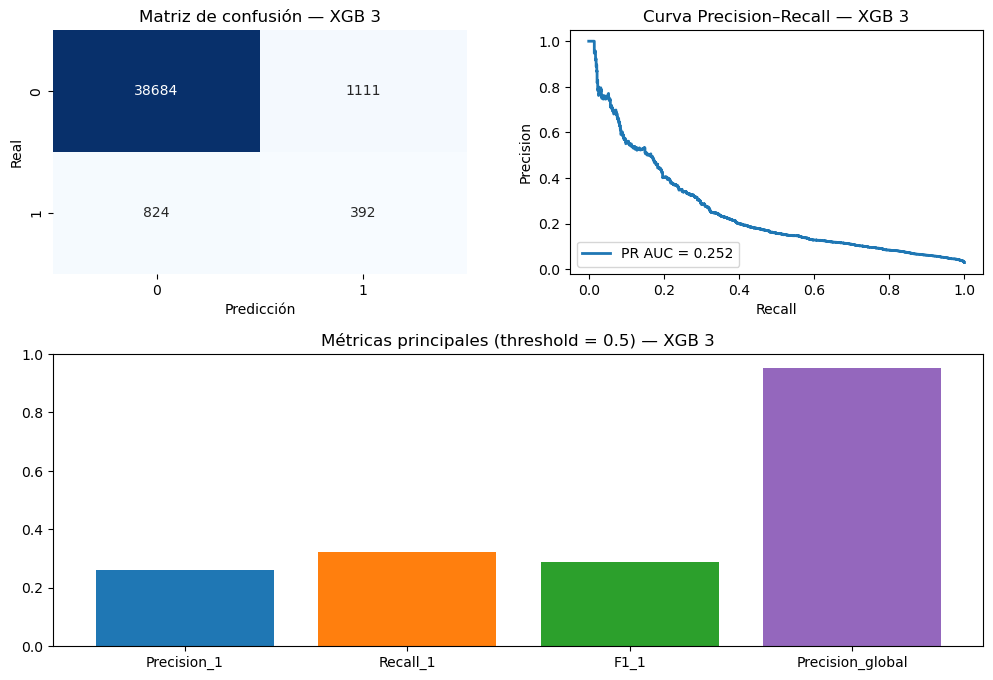

Threshold = 0.5
Precision (clase 1): 0.2608
Recall    (clase 1): 0.3224
F1        (clase 1): 0.2883
PR AUC (Average Precision): 0.2520
Precision global: 0.9528
Tiempo de entrenamiento: 3.8689 segundos



In [72]:
# Evaluamos en test
graficar_modelo(xgb3, X_test, y_test, nombre="XGB 3", threshold=0.5, train_time=train_time_XGB3)


Esta configuración mostró mayor eficencia al bajar el tiempo de entrenamiento (**≈3.9 s**). Sin embargo, el resto de métricas sufrieron una bajada de rendimiento, con un **PR AUC de 0.252** y **F1 DE 0.288**. Esto demuestra que los cambios relacionados a la optimización tuvieron efectos positivos mientras que el resto ,que buscaban robustez, fue lo contrario.

### Experimento 4 

Ahora se aumentó considerablemente la profundidad de los árboles (**max_depth=9**) y se redujo la tasa de aprendizaje (**learning_rate=0.03**) para permitir un aprendizaje más gradual y detallado.
También se disminuyó el peso mínimo por nodo (**min_child_weight=1**) y se eliminaron restricciones adicionales (**gamma=0.0**), haciendo el modelo más flexible y capaz de captar relaciones complejas.
Al mismo tiempo, se aplicaron tasas de muestreo moderadas (**subsample=0.7, colsample_bytree=0.7**) y una regularización ligera (**reg_alpha=0.2, reg_lambda=1.0**) para controlar el sobreajuste.

In [74]:
xgb_4 = XGBClassifier(
    objective="binary:logistic", 
    eval_metric="aucpr",
    n_estimators=2000,         
    learning_rate=0.03,      
    max_depth=9,            
    min_child_weight=1,       
    subsample=0.70,             
    colsample_bytree=0.70,    
    gamma=0.0,
    reg_alpha=0.20,          
    reg_lambda=1.0,           
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

# Entrenamiento

start = time.time()
xgb_4.fit(X_train_res, y_train_res)
train_time_XGB4 = time.time() - start

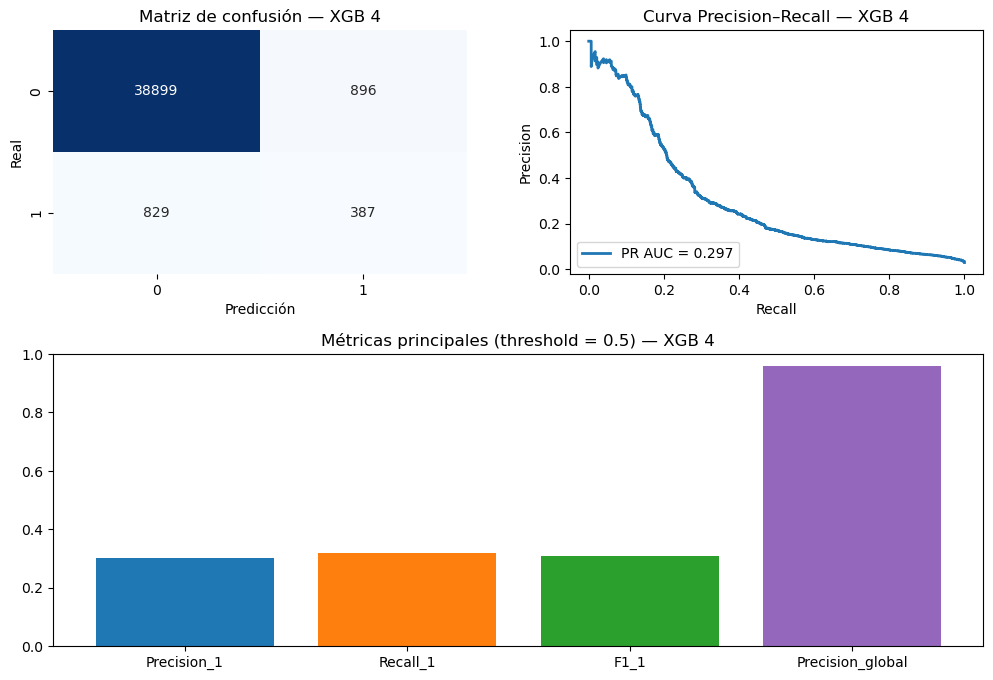

Threshold = 0.5
Precision (clase 1): 0.3016
Recall    (clase 1): 0.3183
F1        (clase 1): 0.3097
PR AUC (Average Precision): 0.2967
Precision global: 0.9579
Tiempo de entrenamiento: 12.2267 segundos



In [75]:
# Evaluamos en test
graficar_modelo(xgb_4, X_test, y_test, nombre="XGB 4", threshold=0.50, train_time=train_time_XGB4)

Con esta configuración  el modelo mantuvo un rendimiento muy sólido, logrando un **F1 de 0.310** y un **PR AUC de 0.297**, los valores más altos hasta el momento. Aunque el tiempo de entrenamiento aumentó ligeramente (**≈12 s**), sigue siendo razonable para la ganancia obtenida en estabilidad y discriminación.

### Experimento 5  

En este experimento se probó la política de crecimiento **"lossguide"**, que controla el crecimiento de los árboles por el número de hojas en lugar de la profundidad, haciendo el modelo más eficiente y flexible.
Se definió **max_leaves=128 y max_bin=512** para permitir árboles más amplios con divisiones más precisas, reduciendo al mismo tiempo la tasa de aprendizaje (**0.02**) para un aprendizaje más progresivo.
Además, se aplicaron tasas de muestreo más restrictivas (**subsample=0.6, colsample_bytree=0.6**) y una regularización ligeramente más fuerte (**reg_alpha=0.3, reg_lambda=1.2**) para evitar el sobreajuste.

In [76]:
xgb5 = XGBClassifier(
    objective="binary:logistic", 
    eval_metric="aucpr",
    n_estimators=2500,
    learning_rate=0.02,
    tree_method="hist",
    grow_policy="lossguide",
    max_depth=0,          
    max_leaves=128,        
    max_bin=512,        
    min_child_weight=1,
    gamma=0.0,
    reg_alpha=0.30,       
    reg_lambda=1.20, 
    subsample=0.60,
    colsample_bytree=0.60,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento

start = time.time()
xgb5.fit(X_train_res, y_train_res)
train_time_XGB5 = time.time() - start

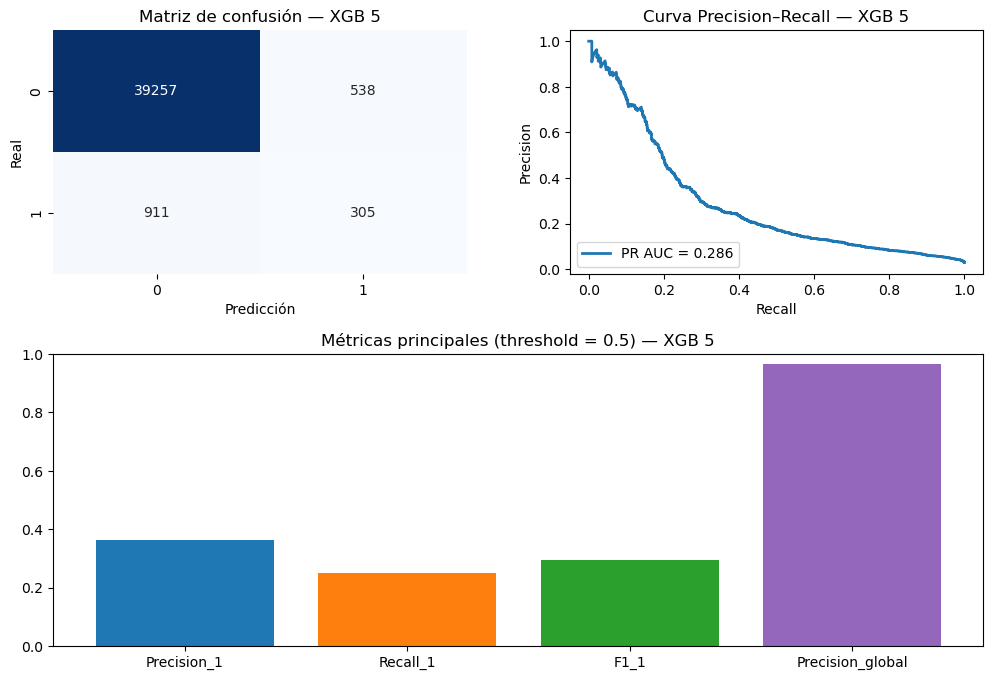

Threshold = 0.5
Precision (clase 1): 0.3618
Recall    (clase 1): 0.2508
F1        (clase 1): 0.2963
PR AUC (Average Precision): 0.2858
Precision global: 0.9647
Tiempo de entrenamiento: 63.6547 segundos



In [77]:
# Evaluamos en test
graficar_modelo(xgb5, X_test, y_test, nombre="XGB 5", threshold=0.50, train_time=train_time_XGB5)

Bajaron el rendimiento de las métricas, aunque sean en menor medidad, con **PR AUC de 0.286** y **F1 de  0.296**. Se podría mantener como un modelo parecido al resto, sino fuera, que el **tiempo** de entrenamiento incremento de forma muy elevada llegando a **un minuto**, debido a la mayor complejidad del modelo en este caso.

### Experimento 6

En esta prueba, con respecto al anterior, se amplían el número **máximo de hojas** a **256** para dar más capacidad al modelo, se relajan ligeramente las restricciones con **subsample=0.70 y colsample_bytree=0.70**, y se reduce la regularización (**reg_alpha=0.20, reg_lambda=1.0**).

In [78]:
xgb_6 = XGBClassifier(
    objective="binary:logistic", 
    eval_metric="aucpr",
    n_estimators=2500,         
    learning_rate=0.02,       
    tree_method="hist",
    grow_policy="lossguide",    
    max_depth=0,               
    max_leaves=256,          
    max_bin=512,              

    min_child_weight=1,        
    gamma=0.0,
    subsample=0.70,
    colsample_bytree=0.70,

    reg_alpha=0.20,          
    reg_lambda=1.0,           
    random_state=42,
    n_jobs=-1
)

# Entrenamos
start = time.time()
xgb_6.fit(X_train_res, y_train_res)
train_time_XGB6 = time.time() - start

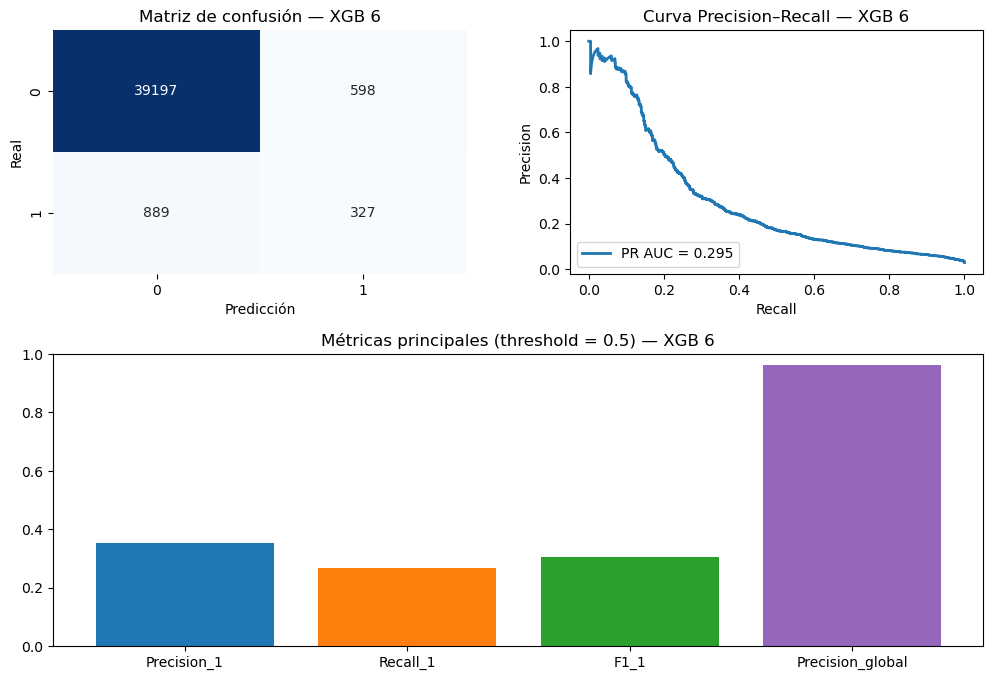

Threshold = 0.5
Precision (clase 1): 0.3535
Recall    (clase 1): 0.2689
F1        (clase 1): 0.3055
PR AUC (Average Precision): 0.2950
Precision global: 0.9637
Tiempo de entrenamiento: 118.9970 segundos



In [83]:
# Evaluamos en test
graficar_modelo(xgb_6, X_test, y_test, nombre="XGB 6", threshold=0.5, train_time=train_time_XGB6)

En este experimento, el modelo mantiene un rendimiento competitivo, logrando un **PR AUC de 0.295** y un **F1 de 0.31**.Sin embargo, el **tiempo** de entrenamiento se incrementó notablemente (**≈119 s**), lo que sugiere que la ganancia en rendimiento viene acompañada de un coste computacional considerable.

### Experimento 7

Aquí se buscó un punto intermedio entre complejidad y eficiencia. Se redujo el **número de árboles** (**n_estimators=1500**) y se aumentó ligeramente la tasa de aprendizaje (**learning_rate=0.04**) para acelerar el entrenamiento.
Además, se ajustaron la profundidad máxima (**max_depth=8**) y el peso mínimo de nodo (**min_child_weight=5**) para controlar el sobreajuste, mientras que se añadió una regularización más fuerte (**reg_alpha=0.4, reg_lambda=1.5**) y un **gamma=0.5** para penalizar divisiones poco útiles.

In [80]:
xgb_7 = XGBClassifier(
    objective="binary:logistic", 
    eval_metric="aucpr",
    n_estimators=1500,          
    learning_rate=0.04,        
    max_depth=8,                
    min_child_weight=5,        
    subsample=0.75,
    colsample_bytree=0.75,
    gamma=0.5,                
    reg_alpha=0.4,          
    reg_lambda=1.5,             
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

# Entrenamos

start = time.time()
xgb_7.fit(X_train_res, y_train_res)
train_time_XGB7 = time.time() - start

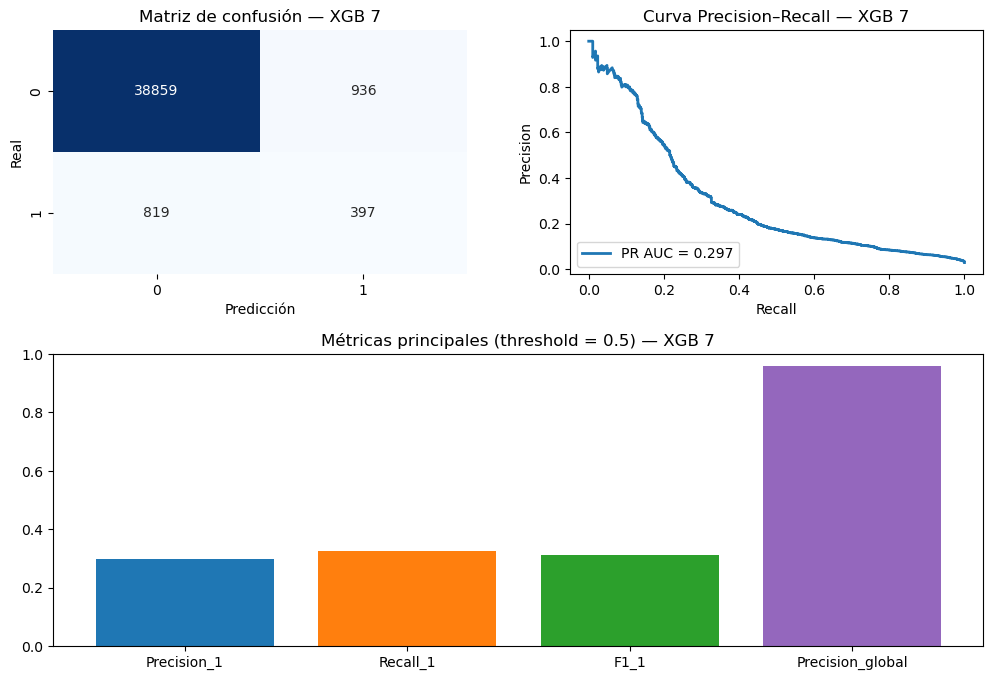

Threshold = 0.5
Precision (clase 1): 0.2978
Recall    (clase 1): 0.3265
F1        (clase 1): 0.3115
PR AUC (Average Precision): 0.2972
Precision global: 0.9572
Tiempo de entrenamiento: 7.6932 segundos



In [81]:
# Evaluamos en test
graficar_modelo(xgb_7, X_test, y_test, nombre="XGB 7", threshold=0.5, train_time=train_time_XGB7)

Este modelo logra mantener muy buen rendimiento como el resto de pruebas, con un **PR AUC de 0.297** y un **F1 de 0.31**, pero reduciendo el **tiempo** de entrenamiento a solo **~7.7 segundos**, una mejora notable en eficiencia. Este buen equilibrio, demuestra que la combinación de regularización más fuerte y menor número de árboles consigue controlar el sobreajuste sin perder capacidad predictiva.


Y como parece que apesar de las distintas pruebas, no hemos conseguido ningún cambio muy significativo. Elegiremos este último experimento para hacer pruebas con el umbral y elegir el que me mejor balance encontremos.

In [82]:
evaluar_modelo(xgb_7, X_test, y_test, nombre="XGB 7", threshold=0.3, train_time=train_time_XGB7)
evaluar_modelo(xgb_7, X_test, y_test, nombre="XGB 7", threshold=0.4, train_time=train_time_XGB7)
evaluar_modelo(xgb_7, X_test, y_test, nombre="XGB 7", threshold=0.5, train_time=train_time_XGB7)
evaluar_modelo(xgb_7, X_test, y_test, nombre="XGB 7", threshold=0.6, train_time=train_time_XGB7)
evaluar_modelo(xgb_7, X_test, y_test, nombre="XGB 7", threshold=0.7, train_time=train_time_XGB7)
evaluar_modelo(xgb_7, X_test, y_test, nombre="XGB 7", threshold=0.8, train_time=train_time_XGB7)

=== Evaluación de XGB 7 (threshold=0.3) ===
Matriz de confusión:
 [[36577  3218]
 [  578   638]]
Precision global: 0.9074
Precision (clase 1): 0.1655
Recall (clase 1): 0.5247
F1 (clase 1): 0.2516
PR AUC (Average Precision): 0.2972
Tiempo de entrenamiento: 7.6932 segundos 

=== Evaluación de XGB 7 (threshold=0.4) ===
Matriz de confusión:
 [[38010  1785]
 [  701   515]]
Precision global: 0.9394
Precision (clase 1): 0.2239
Recall (clase 1): 0.4235
F1 (clase 1): 0.2929
PR AUC (Average Precision): 0.2972
Tiempo de entrenamiento: 7.6932 segundos 

=== Evaluación de XGB 7 (threshold=0.5) ===
Matriz de confusión:
 [[38859   936]
 [  819   397]]
Precision global: 0.9572
Precision (clase 1): 0.2978
Recall (clase 1): 0.3265
F1 (clase 1): 0.3115
PR AUC (Average Precision): 0.2972
Tiempo de entrenamiento: 7.6932 segundos 

=== Evaluación de XGB 7 (threshold=0.6) ===
Matriz de confusión:
 [[39327   468]
 [  906   310]]
Precision global: 0.9665
Precision (clase 1): 0.3985
Recall (clase 1): 0.2549
F1 

## LGBM

### Experimento 1

Esta primera configuración propuso un número moderado de **árboles** (**n_estimators=700**) junto con una tasa de **aprendizaje** reducida (**learning_rate=0.05**) para permitir un aprendizaje progresivo.
La complejidad del modelo se controló mediante un número intermedio de **hojas** (**num_leaves=63**), un mínimo de **muestras por hoja** (**min_child_samples=40**) y una **profundidad** ilimitada (**max_depth=-1**).
Además, se aplicó **muestreo** aleatorio tanto de filas como de características (**subsample=0.8, colsample_bytree=0.8**) con el fin de mejorar la generalización, junto con una **regularización** explícita ligera (**reg_alpha=0.0, reg_lambda=1.0**).

In [84]:
lgb1 = LGBMClassifier(
    
    objective="binary",
    n_estimators=700,
    learning_rate=0.05,
    num_leaves=63,
    max_depth=-1,
    min_child_samples=40,
    reg_alpha=0.0,
    reg_lambda=1.0,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento

start = time.time()
lgb1.fit(X_train_res, y_train_res)
train_time_LGB1 = time.time() - start

[LightGBM] [Info] Number of positive: 47752, number of negative: 159176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 206928, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230766 -> initscore=-1.203990
[LightGBM] [Info] Start training from score -1.203990


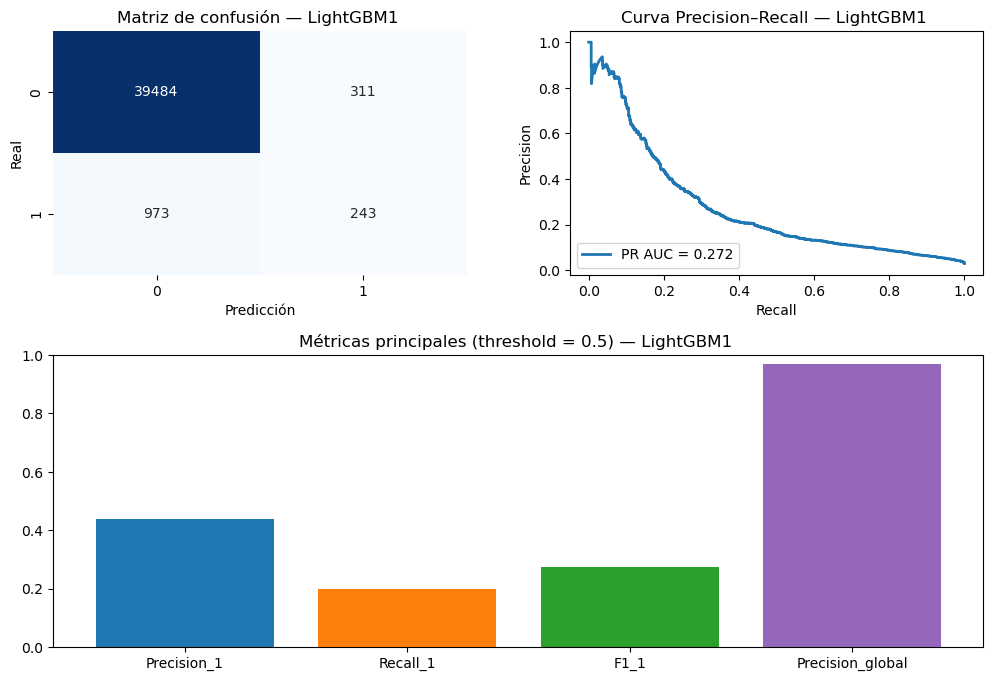

Threshold = 0.5
Precision (clase 1): 0.4386
Recall    (clase 1): 0.1998
F1        (clase 1): 0.2746
PR AUC (Average Precision): 0.2724
Precision global: 0.9687
Tiempo de entrenamiento: 7.8676 segundos



In [85]:
# Evaluamos en test
graficar_modelo(lgb1, X_test, y_test, nombre="LightGBM1 ", threshold=0.5, train_time=train_time_LGB1)

Esta primera prueba muestra que este algortimo es tan prometedor como XGBoost, alcanzando un **PR AUC de 0.272** y un **F1 de 0.274**, valores cercanos a los obtenidos con el otro modelo, y con  **tiempo** de entrenamiento similar, (**≈8 s**). Y a pesar de que muestra un recall relativamente bajo comparado al resto, muestra una base sólida para realizar pruebas.

### Experimento 2

Se aumentó la capacidad del modelo con más **árboles** (**n_estimators=1500**) y un **aprendizaje** más pausado (**learning_rate=0.02**), buscando mayor fineza en los patrones. También se limitó la **profundidad** máxima (**max_depth=6**) y se endureció el requisito **mínimo de muestras** por hoja (**min_child_samples=80**), lo que hace al modelo más conservador. Además, se introdujo **regularización** explícita (**reg_alpha=0.40, reg_lambda=2.0**) y se redujo el **muestreo** tanto de filas (**subsample=0.65**) como de columnas (**colsample_bytree=0.75**), con el objetivo de frenar el sobreajuste.

In [91]:
lgb2 = LGBMClassifier(
    objective="binary",
    n_estimators=1500, 
    learning_rate=0.02,
    num_leaves=63,
    max_depth=6,   
    min_child_samples=80,
    reg_alpha=0.40,  
    reg_lambda=2.0,  
    subsample=0.65, 
    subsample_freq=1,
    colsample_bytree=0.75, 
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Entrenamiento

start = time.time()
lgb2.fit(X_train_res, y_train_res)
train_time_LGB2 = time.time() - start

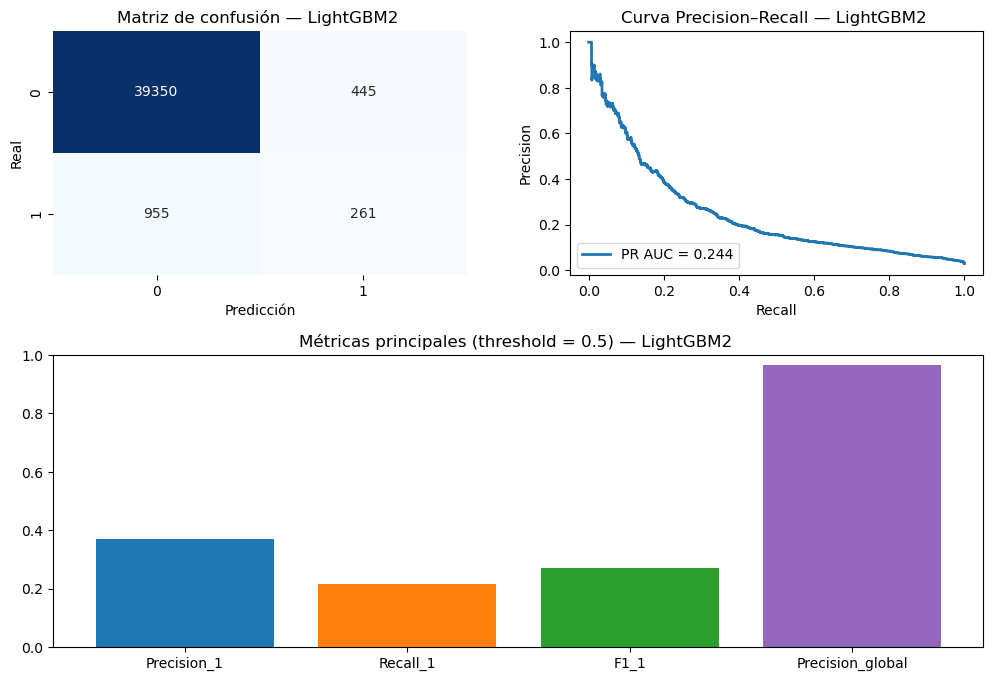

Threshold = 0.5
Precision (clase 1): 0.3697
Recall    (clase 1): 0.2146
F1        (clase 1): 0.2716
PR AUC (Average Precision): 0.2445
Precision global: 0.9659
Tiempo de entrenamiento: 8.7489 segundos



In [92]:
# Evaluamos en test
graficar_modelo(lgb2, X_test, y_test, nombre="LightGBM2 ", threshold=0.5, train_time=train_time_LGB2)

El resultado fue un **PR AUC de 0.244** y **F1 de 0.272** y un tiempo de entrenamiento similar. Aunque el recall subió ligeramente, la precisión cayó y el PR AUC se redujo de forma notable. En la práctica, este ajuste clasifó mas casos como phising de lo necesario, bajando el rendimiento.

### Experimento 3

Ahora se buscó un punto intermedio entre las dos pruebas anteriores. Se redujo el número de **árboles** (**n_estimators=1200**), pero con una tasa de **aprendizaje** intermedio (**learning_rate=0.03**). Se aumentó la complejidad permitiendo más **hojas** (**num_leaves=127**) y sin límite de **profundidad** (**max_depth=-1**). A la vez, se reforzó la **regularización** (**reg_alpha=0.30 y reg_lambda=1.20**), se exigió un número mínimo de ejemplos por hoja (**min_child_samples=60**) y se aplicó mayor aleatoriedad (**subsample y colsample=0.70**).

In [94]:
lgb3 = LGBMClassifier(
    
    objective="binary",
    n_estimators=1200,  
    learning_rate=0.03, 
    num_leaves=127, 
    max_depth=-1, 
    min_child_samples=60, 
    reg_alpha=0.30, 
    reg_lambda=1.20, 
    subsample=0.70, 
    subsample_freq=1, 
    colsample_bytree=0.70, 
    random_state=42,
    n_jobs=-1
)

# Entrenamos

start = time.time()
lgb3.fit(X_train_res, y_train_res)
train_time_LGB3 = time.time() - start

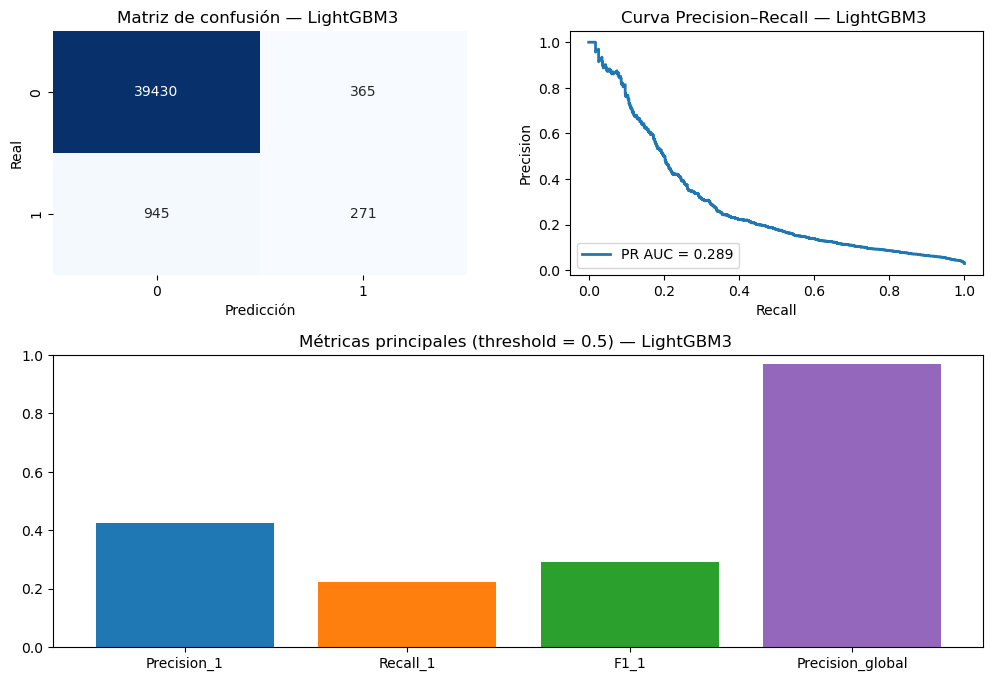

Threshold = 0.5
Precision (clase 1): 0.4261
Recall    (clase 1): 0.2229
F1        (clase 1): 0.2927
PR AUC (Average Precision): 0.2891
Precision global: 0.9681
Tiempo de entrenamiento: 22.0750 segundos



In [118]:
# Evaluamos en test
graficar_modelo(lgb3, X_test, y_test, nombre="LightGBM3 ", threshold=0.5, train_time=train_time_LGB3)

Esta combinación mostró una mejoría notable, con **PR AUC de 0.289**  y **F1 de 0.2927**. Y a pesar de que el tiempo de entrenamiento subió a 22 segundos, el modelo empieza a mostrar indicio de ser uno competitvo en relación al resto.

### Experimento 4

En esta prueba se apostó por maximizar la capacidad del modelo: se subieron los árboles (**n_estimators=2000**) y se bajó el paso (**learning_rate=0.02**) para un aprendizaje más fino. Se incrementó la expresividad con más hojas (**num_leaves=128, max_depth=-1**), se mantuvo una regularización moderada (**reg_alpha=0.30, reg_lambda=1.20**) para podar splits débiles y se suavizó el sobreajuste exigiendo un mínimo de ejemplos por hoja (**min_child_samples=40**). 

In [96]:
lgb4 = LGBMClassifier(
    objective="binary",
    n_estimators=2000,   
    learning_rate=0.02,     
    num_leaves=128,       
    max_depth=-1,
    min_child_samples=40,   
    reg_alpha=0.30,        
    reg_lambda=1.20,        
    subsample=0.70,         
    subsample_freq=1,
    colsample_bytree=0.70,  
    random_state=42,
    n_jobs=-1,
)

# Entrenamos
start = time.time()
lgb4.fit(X_train_res, y_train_res)
train_time_LGB4 = time.time() - start

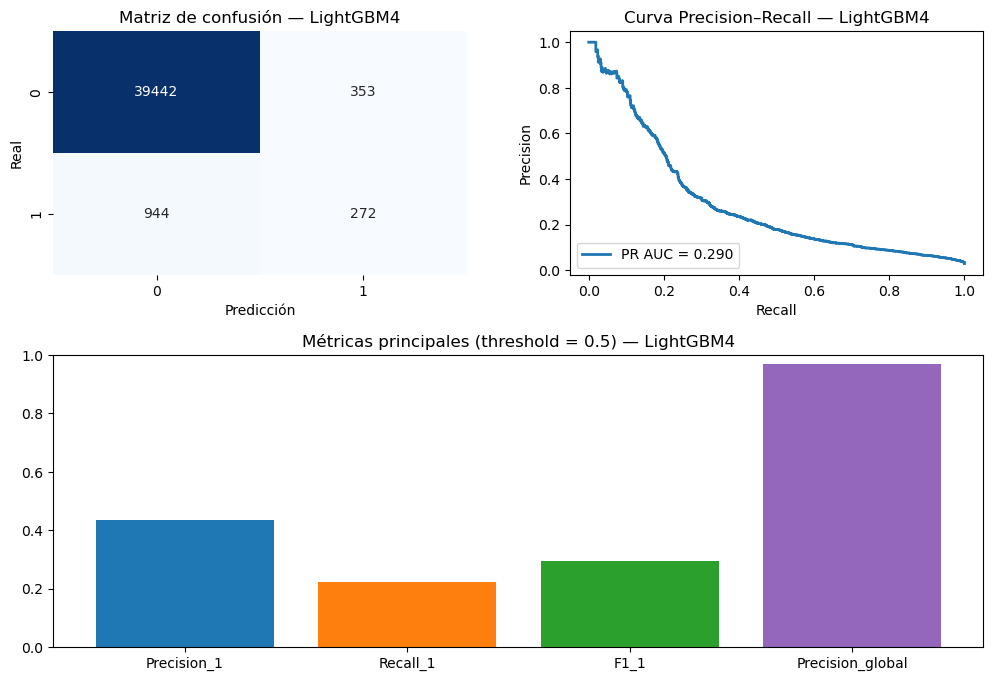

Threshold = 0.5
Precision (clase 1): 0.4352
Recall    (clase 1): 0.2237
F1        (clase 1): 0.2955
PR AUC (Average Precision): 0.2902
Precision global: 0.9684
Tiempo de entrenamiento: 37.9135 segundos



In [98]:
# Evaluamos en test
graficar_modelo(lgb4, X_test, y_test, nombre="LightGBM4", threshold=0.5, train_time=train_time_LGB4)

La configuración mantiene un rendimiento muy similar al anterior, con **un PR AUC de 0.290** y un **F1 de 0.296**. Sin embargo aunque haya una ligera mejora en las métricas el **tiempo de entrenamiento** subió a **~38 segundo**. Con estas pruebas vemos que este podría ser el modelo con mejor capacidad discriminativa a pesar del aumento de tiempo. Y también podríamos haber alcanzado un punto de estabilidad donde no podremos alcanzar muchos mejores resultados, aun así, se harán un par de pruebas más.

### Experimento 5

Ahora redujo ligeramente el número de árboles (**n_estimators=1400**) y se aumentó la tasa de aprendizaje (**learning_rate=0.03**) para lograr un entrenamiento más rápido.
Se mantuvo una alta capacidad de representación con 127 hojas por árbol (**num_leaves=127**) y la regularización anterior.
Además, se aumentó el muestreo tanto de filas como de columnas (**subsample=0.80, colsample_bytree=0.80**) y se exigieron más muestras por hoja (**min_child_samples=50**).

In [101]:
lgb5 = LGBMClassifier(
    objective="binary",
    n_estimators=1400,      
    learning_rate=0.03, 
    num_leaves=127,        
    max_depth=-1,
    min_child_samples=50,   
    reg_alpha=0.30,
    reg_lambda=1.20,
    subsample=0.80,       
    subsample_freq=1,
    colsample_bytree=0.80,  
    random_state=42,
    n_jobs=-1
)

# Entrenamiento

start = time.time()
lgb5.fit(X_train_res, y_train_res)
train_time_LGB5 = time.time() - start

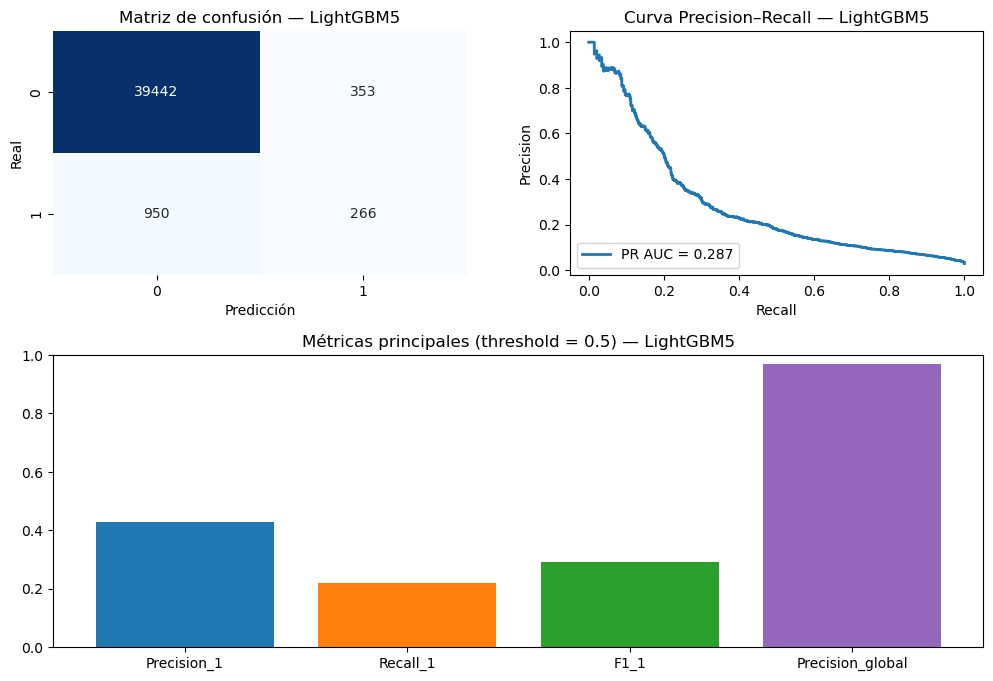

Threshold = 0.5
Precision (clase 1): 0.4297
Recall    (clase 1): 0.2188
F1        (clase 1): 0.2899
PR AUC (Average Precision): 0.2875
Precision global: 0.9682
Tiempo de entrenamiento: 28.4469 segundos



In [103]:
# Evaluamos en test
graficar_modelo(lgb5, X_test, y_test, nombre="LightGBM5", threshold=0.5, train_time=train_time_LGB5)

El modelo ha mantenido un rendimiento muy similar a las versiones anteriores, con un **PR AUC de 0.288** y un **F1 de 0.290**.También el tiempo de entrenamiento se redujo (**≈28 s**), lo que indica que es un equilibrio entre los 2 expeeriemntos anteriores. Pero aun así, no es resultado muy diferente al resto, apoyando más la teoría que ya se alcanzó un punto estable de rendimiento.

### Experimento 6

Como prueba final, se usará la misma configuración que el experimento 4, el modelo con mayor capacidad discriminativa. Pero se activará la opción de **class_weight="balanced"**, con el objetivo de comprobar si el ajuste de peso, apesar de haber aplicado Smote, mejora el equilibrio de métricas.

In [119]:
lgb6 = LGBMClassifier(
    objective="binary",
    n_estimators=2000,   
    learning_rate=0.02,     
    num_leaves=128,       
    max_depth=-1,
    min_child_samples=40,   
    reg_alpha=0.30,        
    reg_lambda=1.20,        
    subsample=0.70,         
    subsample_freq=1,
    colsample_bytree=0.70,  
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
# Entrenamiento

start = time.time()
lgb6.fit(X_train_res, y_train_res)
train_time_LGB6 = time.time() - start

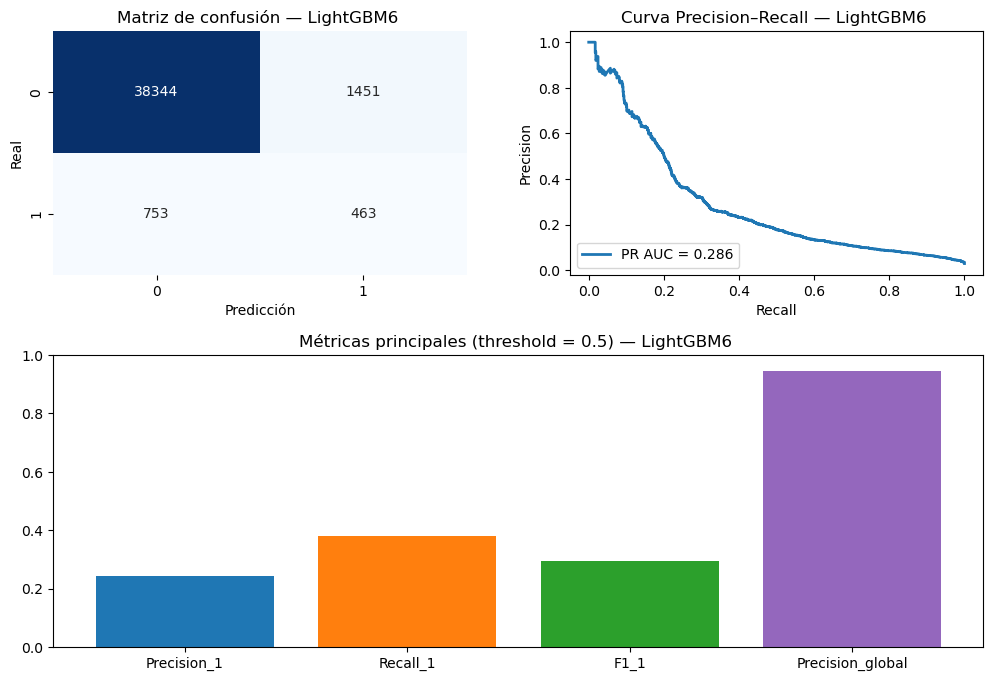

Threshold = 0.5
Precision (clase 1): 0.2419
Recall    (clase 1): 0.3808
F1        (clase 1): 0.2958
PR AUC (Average Precision): 0.2856
Precision global: 0.9463
Tiempo de entrenamiento: 108.1594 segundos



In [120]:
# Evaluamos en test
graficar_modelo(lgb6, X_test, y_test, nombre="LightGBM6 ", threshold=0.5, train_time=train_time_LGB6)

En general, mostró resultados similares o un poco inferiores al cuarto, con un **PR AUC de 0.286** y **F1 de 0.296**. Sin embargo, subió de gran forma el **tiempo** de entrenamiento, llegando a los **108 segundos**. Con todo esto, no da ninguna razón para mantener esta opción


Con esta última prueba no me hemos conseguido cambiar de forma positiva el rendimiento del modelo, con lo que pararemos las pruebas y buscaremos el mejor umbral para el mejor modelo encontrado hasta ahora, el del experimento 4.

In [100]:
evaluar_modelo(lgb4, X_test, y_test, nombre="LightGBM4", threshold=0.3, train_time=train_time_LGB4)
evaluar_modelo(lgb4, X_test, y_test, nombre="LightGBM4", threshold=0.4, train_time=train_time_LGB4)
evaluar_modelo(lgb4, X_test, y_test, nombre="LightGBM4", threshold=0.55, train_time=train_time_LGB4)
evaluar_modelo(lgb4, X_test, y_test, nombre="LightGBM4", threshold=0.6, train_time=train_time_LGB4)
evaluar_modelo(lgb4, X_test, y_test, nombre="LightGBM4", threshold=0.7, train_time=train_time_LGB4)
evaluar_modelo(lgb4, X_test, y_test, nombre="LightGBM4", threshold=0.8, train_time=train_time_LGB4)

=== Evaluación de LightGBM4 (threshold=0.3) ===
Matriz de confusión:
 [[38621  1174]
 [  798   418]]
Precision global: 0.9519
Precision (clase 1): 0.2626
Recall (clase 1): 0.3438
F1 (clase 1): 0.2977
PR AUC (Average Precision): 0.2902
Tiempo de entrenamiento: 37.9135 segundos 

=== Evaluación de LightGBM4 (threshold=0.4) ===
Matriz de confusión:
 [[39128   667]
 [  879   337]]
Precision global: 0.9623
Precision (clase 1): 0.3357
Recall (clase 1): 0.2771
F1 (clase 1): 0.3036
PR AUC (Average Precision): 0.2902
Tiempo de entrenamiento: 37.9135 segundos 

=== Evaluación de LightGBM4 (threshold=0.55) ===
Matriz de confusión:
 [[39546   249]
 [  966   250]]
Precision global: 0.9704
Precision (clase 1): 0.5010
Recall (clase 1): 0.2056
F1 (clase 1): 0.2915
PR AUC (Average Precision): 0.2902
Tiempo de entrenamiento: 37.9135 segundos 

=== Evaluación de LightGBM4 (threshold=0.6) ===
Matriz de confusión:
 [[39615   180]
 [  990   226]]
Precision global: 0.9715
Precision (clase 1): 0.5567
Recall (